# Project 2 - Forecast correction

## General Oveview

### Assignment Overview

The aim of the assignment is to correct ensemble forecasts to be able to predict with more accuracy temperatures in a small region in Brussel.

We will use machine learing techniques to correct the forecasts for 2024 given past ensemble forecasts and the correspond measured temperature value at the vlinder station.

https://www.ecmwf.int/en/newsletter/166/meteorology/statistical-post-processing-ensemble-forecasts-belgian-met-service

### Data Preprocessing

We need high quality data before we can train our models. We will first analyse our target data (measured temperatures at vlinder station). We will see that some measurement are erroneous and thus remove them. We will then analyse features from the ensemble forecast and relate them to our target data to make informed choices on which features to keep for our training.

In order to visualize dependencies within our data more easily all the different ensemble forecasts are not directly merged into one dataframe, they are kept in a list of tuples (date, fc) where date is a string representing the start date of the forecast and fc is a dataframe holding the ensemble forcast.


### Used Algorithms

- Linear regression
- Random forest regression
- TBD (Nonhomogeneous Gaussian regression, NN?)

### Nice things to have
- [ ] Use pipelines to automate operations
- [x] Consumption of energy + log
- [ ] Time function (+ display number of training samples) 

### Personal notes
- We dont especially need to avoid duplicate data, we can keep it in different forecast. However we need to be carefull with data leakage (between train, validation and test set)
- [ ] Use past data pf 2024 to add to training data
- What data do we keep for selection [Feature Selection](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/)?
    - Data selection will depend on algo used
    - correlation analysis/feature importance ranking/Principal Component Analysis 

- RandomForest Regressor
- Nonhomogeneous Gaussian regression
- Look at the difference from one day to the other in forecast (instead of computing absolute values)
### Misc
- Name of station ? ecmwf? station?

In [2]:
%pip install codecarbon
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [170]:
from codecarbon import track_emissions, EmissionsTracker
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import math
import glob
import datetime
from functools import partial, reduce, wraps
from collections import defaultdict  
from itertools import chain, accumulate
import random
import operator
from abc import ABC, abstractmethod
from scipy.stats import linregress
import time as time_tool
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV
random.seed(42)
# 0 degre Celius in Kelvin
C_0 = 273.15
#Dict to link target metrics from forecast with an eventual required scaling constant
Const_Conversion = {'t2m' : C_0, 'd2m' : C_0, 'skt' : C_0}
plt.style.use('seaborn-v0_8-colorblind')

#from https://stackoverflow.com/questions/16739290/composing-functions-in-python
def compose (*functions):
    """
        Enables function composition
    """
    def inner(arg):
        for f in reversed(functions):
            arg = f(arg)
        return arg
    return inner

def identity(x):
    return x

# from https://realpython.com/primer-on-python-decorators/
def timer(func):

    """Print the runtime of the decorated function"""

    wraps(func)

    def wrapper_timer(*args, **kwargs):
        rows = None
        if isinstance(args[0], pd.DataFrame):
            rows = args[0].shape[0]
        start_time = time_tool.perf_counter()

        value = func(*args, **kwargs)

        end_time = time_tool.perf_counter()

        run_time = end_time - start_time

        print(f"Finished {func.__name__}() in {run_time:.4f} secs for {rows} elements")

        return value

    return wrapper_timer

# Match data sets

We will first build a class to handle ensemble forecasts.

Then we will build a class to handle Vlinder data.

Ensemble forecasts and vlinder data are both in their own class in order to be able to make queries and generate new sets of data.
This makes it easier to display data and try out multiple things.

Using those two classes we will make assumptions on the data and then match the measured temperatures to the right date in the ensemble forecast.

## Forecast data sets

Class handeling ensemble forecasts. This is done to be able to create and access forecasts in a determined way as well as computing helpfull information.


- `get_ensemble_forecast(date)` gives the ensemble forecast starting at `date`.
- `get_df()` returns one dataframe with all ensemble forecasts where forecasts are indexed by their starting date

In [4]:
# Create of Main DataFrame
class EnsembleForecast:
    def __init__(self):
        self.df = self._create_df()

    def _extract_datetime(self, file_name):
        """
            Extracts datetime object from file_name 
            Returns datetime if successful, None otherwise
        """
        try:
            strings_of_date = file_name.replace('.', '_').split('_')[1:4]
            d, m, y = tuple(map(int, strings_of_date))
            return datetime.datetime(y, m, d)
        except Exception as e:
            print(f"Forecast csv does not respect date_month_year.csv format: {e}\n {file_name} dropped")
        return None

    def _create_df(self):
        """
            Creates dataframe where each ensemble forecast is accessible by its start date
        """
        df_f = pd.DataFrame()
        for file_name in glob.glob("forecast/"+'*.csv'): 
            start_time = self._extract_datetime(file_name)
            if start_time != None:
                to_add = pd.read_csv(file_name)
                to_add['Start'] = start_time
                df_f = pd.concat([df_f, to_add])
            else:
                pass
        self.time_str = df_f.columns.to_list()[0]
        df_f = df_f.sort_values(by='Start', kind='mergesort')
        return df_f.set_index(['Start', 'time']).sort_index()

    def get_df(self):
        return self.df

    def get_min_max(self):
        """
            Returns earliest and latest date available in the ensemble forecasts
        """
        select_time = self.df.index.get_level_values('time')
        return (select_time.min(), select_time.max())
        
    def get_start_dates(self):
        """
            Returns a list start date of ensemble forecast
        """
        lst = list(set(self.df.index.get_level_values('Start')))
        lst.sort()
        return lst

    def get_ensemble_forecast(self, date):
        """
            Returns ensemble forecast given date
            date format (%Y-%M-%D %h:%m:%s)
        """
        return self.df.loc[date]

forecast_data = EnsembleForecast()

forecast_min, forecast_max = forecast_data.get_min_max()

df_1 = forecast_data.get_ensemble_forecast("2023-03-01 00:00:00")
df_all = forecast_data.get_df()
print(forecast_data.get_min_max())
df_all.to_csv('tmp.csv')

('2023-02-01 00:00:00', '2023-07-07 00:00:00')


## Vlinder Data

Vlinder data set is inside a Vlinder class. This makes it easier to query and display subsets of data

We need to check for inconsitent data points in the the vlinder set and then resample it to match the ensemble forecast

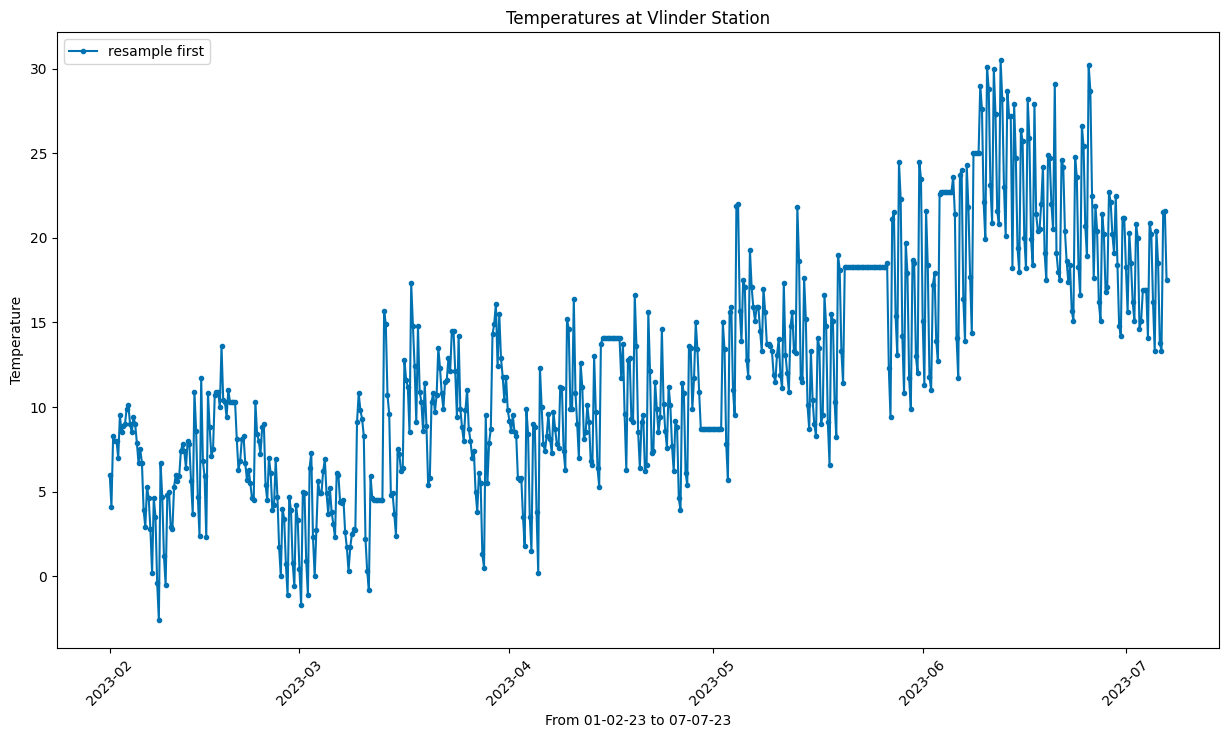

In [5]:
class Vlinder: 
    """
        Class that represents Vlinder data
        Holds original data in self.df 
        Holds resampled data in self.resample
    """
    
    def __init__(self, path_to_csv):
        self.df = pd.read_csv(path_to_csv)
        self.temp_str = self.df.columns.tolist()[0]
        self.time_str = self.df.columns.tolist()[1]
        self.df[self.time_str] = pd.to_datetime(self.df[self.time_str])
        self.resample = {"first" :  self.df.set_index(self.time_str).resample('6h').first().reset_index(),
                        "mean" : self.df.set_index(self.time_str).resample('6h').mean().reset_index()}

    def apply_dates_resize(self, first, snd):
        """
            Does a partial application of dates as we often want the same dates for different dataframes
        """
        return partial(self.resize_on_time, start=first, finish=snd)

    #TODO refactore horrible code
    def _get_time(self, df, start, finish):
        """
            Helper function to set start and finish to the min
            Start and finish can be either None, string or datetime
            Returns datetime object
        """
        if start is None: 
            start = self.earliest(df)
        elif isinstance(start, str):
            start = datetime.datetime.strptime(start, "%Y-%m-%d %H:%M:%S")
        else: 
            pass
        if finish is None: 
            finish = self.latest(df) 
        elif isinstance(finish, str):
            finish = datetime.datetime.strptime(finish, "%Y-%m-%d %H:%M:%S")
        else:
            pass
        return (start, finish)
        
    
    def dataframe_of_string(func):
        """
            Decorator function used to convert input dataframe string into actual dataframe
            If passed in argument is already a dataframe does nothing and passes data framethrough
            Carefull: input type is a string, new type is a dataframe
        """
        def wrapper(self, type="df", *args, **kwargs):
            if isinstance(type, str):
                type = self.select_type(type)
            return func(self, type, *args, **kwargs)
        return wrapper

    #Does not work well when chaining decorators together => Unused atm
    def handle_time(func):
        """
            Decorator used to handle start and finish times
        """
        def wrapper(self, *args, **kwargs):
            if start is None:
                start = self.earliest()
            if finish is None:
                finish = self.latest()
            return func(self, df, start, finish, *args, **kwargs)
        return wrapper

    
    def select_type(self, type="df"):
        """
            Returns dataframe corresponding to type
            types available: 
            - df : original dataframe
            - mean : dataframe resampled on mean
            - first : dataframe resampled on first
        """
        df = None
        match type:
            case "df":
                df = self.df
            case "mean":
                df = self.resample["mean"]
            case "first":
                df = self.resample["first"]
            case _ :
                raise ValueError(f"dataframe {type} does not exist")
        return df
    
    @dataframe_of_string
    def earliest(self, type="df"):
        """
            Returns earliest date in dataframe
        """
        return min(type[self.time_str])

    @dataframe_of_string
    def latest(self, type="df"):
        """
            Returns latest date in dataframe
        """
        return max(type[self.time_str])

    def plot(self, start=None, finish=None):
        """
            Plots original data points as well as resampeled on mean and first
        """
        start , finish = self._get_time(self.df, start, finish)

        # partial application of dates
        select_df = self.apply_dates_resize(start, finish)

        mean = select_df("mean")
        first = select_df("first")
        base = select_df("df")
        
        plt.figure(figsize=(15, 8))
        plt.plot(first[self.time_str], first[self.temp_str], label='resampled first', marker='o', markersize=2, linewidth=1)
        plt.plot(mean[self.time_str], mean[self.temp_str], label='resampled mean',  marker='s', markersize=2, linewidth=1)
        #plt.plot(base[self.time_str], base[self.temp_str], label='original', linestyle='--', linewidth=0.7)
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()
    
    @dataframe_of_string
    def plot_one(self, type="df", start=None, finish=None, info="df"):
        """
            Plots one of the dataframes, either df, mean or first
        """
        start , finish = self._get_time(type, start, finish)
        df_resize = self.resize_on_time(type, start, finish)
        plt.figure(figsize=(15, 8))
        plt.plot(df_resize[self.time_str], df_resize[self.temp_str], marker='o',  markersize=3, label=info) #cannot use type as label as it has been changed to dataframe through decorator
        plt.legend(loc='upper left')
        plt.xlabel(f"""From {start.strftime("%d-%m-%y")} to {finish.strftime("%d-%m-%y")}""")
        plt.ylabel('Temperature')
        plt.title(f'Temperatures at Vlinder Station')
        plt.xticks(rotation=45)
        plt.show()

    @dataframe_of_string
    def resize_on_time(self, type="df", start=None, finish=None):
        """
            Returns new data frame with values between start and finish
            type specifies on which dataframe to apply resizing (df for original, mean for resample mean and first for resample first)
            Format (%Y-%M-%D %h:%m:%s)
            
            On why start and finish = None: https://stackoverflow.com/questions/1802971/nameerror-name-self-is-not-defined
        """
        start , finish = self._get_time(type, start, finish)
        assert start >= self.earliest(type), f"{start} does not exist in dataframe"
        assert finish <= self.latest(type), f"{finish} dies not exist in dataframe"
        return type[(type[self.time_str] >= start) & (type[self.time_str] <= finish)]  

    @dataframe_of_string
    def drop_between(self, type="df", start=None, finish=None):
        """
        Drops values between [start, finish].
        If string is passed, returns new dataframe with dropped values.
        If dataframe is passed, exculdes values from that dataframe
        """
        start , finish = self._get_time(type, start, finish)
        before = type[type[self.time_str] < start]
        after = type[type[self.time_str] > finish]
        return pd.concat([before, after])

    @dataframe_of_string
    def get_cst_intervals(self, type="df"):
        """
            Returns start, end and timedelta of all constant intervals in passed dataframe
        """
        #from https://stackoverflow.com/questions/66684957/is-there-a-faster-way-for-finding-the-range-of-constant-values-in-a-dataframe
        #Compares current element with prev, if (not equal) => True (1), else False (0). cumulative sum then adds.
        #If different sum goes up, else stays constant
        df = type
        groupr = df.temp.ne(df.temp.shift()).cumsum()
        #creates group of (nb, timestamp)
        mapper = list(zip(groupr, df.datetime))
        #from https://stackoverflow.com/questions/71945206/keep-duplciate-items-in-list-of-tuples-if-only-the-first-index-matches-between-t
        dct = defaultdict(list)
        for tup in mapper:
            first, _ = tup
            dct[first].append(tup)
            onlydups = [lst for firstelem, lst in dct.items() if len(lst) > 1]
        #only dups is a list of list with duplicate items
        min_max_lst = []
        for dup in onlydups:
            start = dup[0][1]
            end = dup[-1][1]
            min_max_lst.append((start, end, end - start))
        return min_max_lst

    @dataframe_of_string
    def drop_cst(self, type="df", max_delta=6):
        """
            Keeps all constant time intervals that are stricly bigger than max_delta
            Computes const values through get_cst_intervals
        """
        df = type
        min_max_lst = self.get_cst_intervals(df)
        for timestamps in min_max_lst:
            fst = str(timestamps[0])
            snd = str(timestamps[1])
            delta = (pd.to_datetime(snd) - pd.to_datetime(fst)) / np.timedelta64(1, 'h')
            if (delta > max_delta):
                df = vlinder_data.drop_between(df, start=fst, finish=snd)
        return df

vlinder_data = Vlinder('vlinder19_2023.csv')

#Plot vlinder data on time frame of forecast date avaiable
vlinder_data.plot_one(type="first", start=forecast_min, finish=forecast_max, info="resample first")

We can see from our resampled data that there are multiple periods where temperature seems to be constant. This probably indicates a measument error. We will exclude all those inadequat values from our data.

We compute all constant time intervals through the function `get_cst_intervals()`. We can then drop them by calling `drop_cst(df, max_delta)`, `max_delta` representing consecutive constant time intervals to keep (-> if max_delta = 6, we keep all intervals that are constant on 6hours intervals or less).

We do this because it might be possible that by chance, measured temperatures on consecutive time intervals are the same. However a too long constant interval probably indicates a measurement error.

It is usefull to see what are the most common intervals where const values appear.

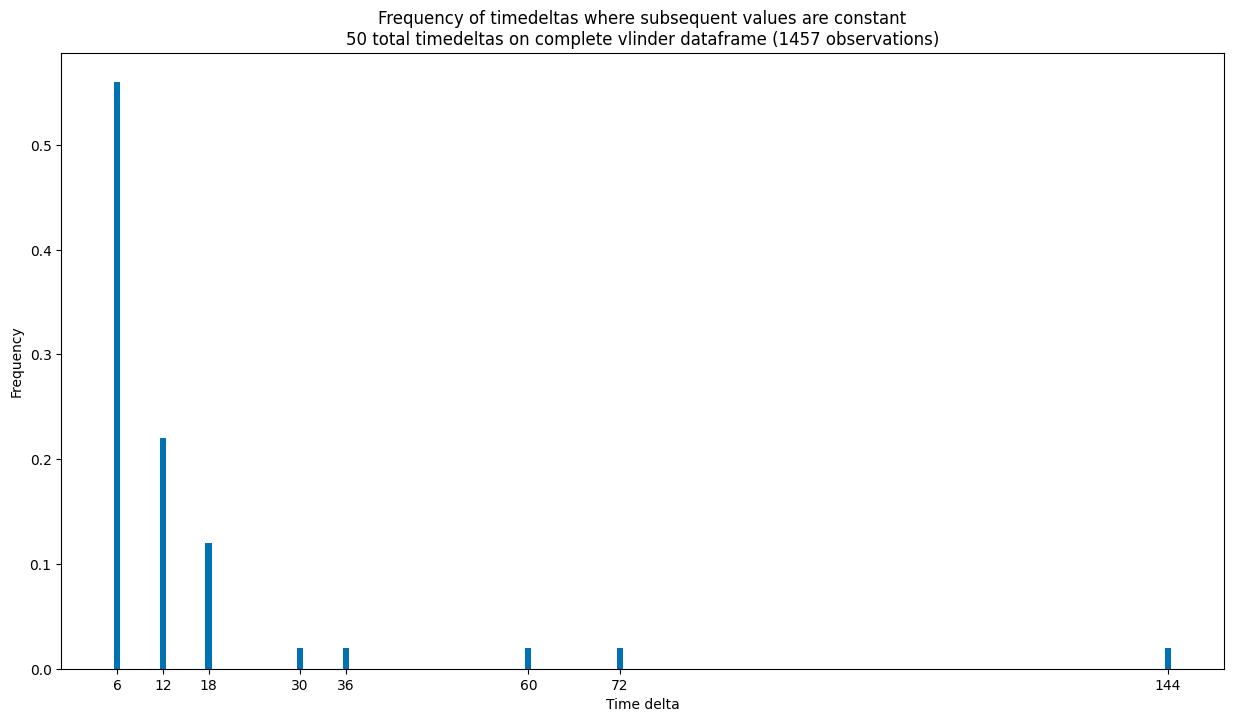

In [6]:
cst_intervals_first = vlinder_data.get_cst_intervals("first")
total_obs = len(vlinder_data.select_type("first"))
# makes list of time deltas
time_delta = list(map(lambda x : x[2], cst_intervals_first))
time_delta_to_hours = (list(map(lambda x : x.total_seconds() / 3600, time_delta)))
total_cst_elements = len(time_delta)
time, occ = np.unique(time_delta_to_hours, return_counts=True)
occ = list(map(lambda x : x / len(time_delta), occ))
plt.figure(figsize=(15, 8))
plt.bar(time, occ)
plt.xlabel('Time delta')
plt.ylabel('Frequency')
plt.xticks(time)
plt.title(f'Frequency of timedeltas where subsequent values are constant\n{total_cst_elements} total timedeltas on complete vlinder dataframe ({total_obs} observations)')
plt.show()

In [7]:
print(occ[0] + occ[1]) 

0.78


Intervals of 6 and 12 hours where consecutive values are constant represent 78% of our total time deltas. It might be probable that by random chance two intervals within 12 hours are similar. (6 hours means 2 consecutive values, 12 hours means 3 consecutive values).

NOTE: when running different models, best results where achieved when max_delta = 0 (no constant intervals are kept). Correlation between `t2m` (temperature at 2 meters from ensemble forecast) and `temp` (measured temperature at station) is also highest when max_delta = 0. Those are not are really accurate method of drawing conclusions, we should do Hypothesis testing to see what conculusions we can draw.

`drop_cst(max_delta)` is a function that drops all time intervals bigger than its given argument

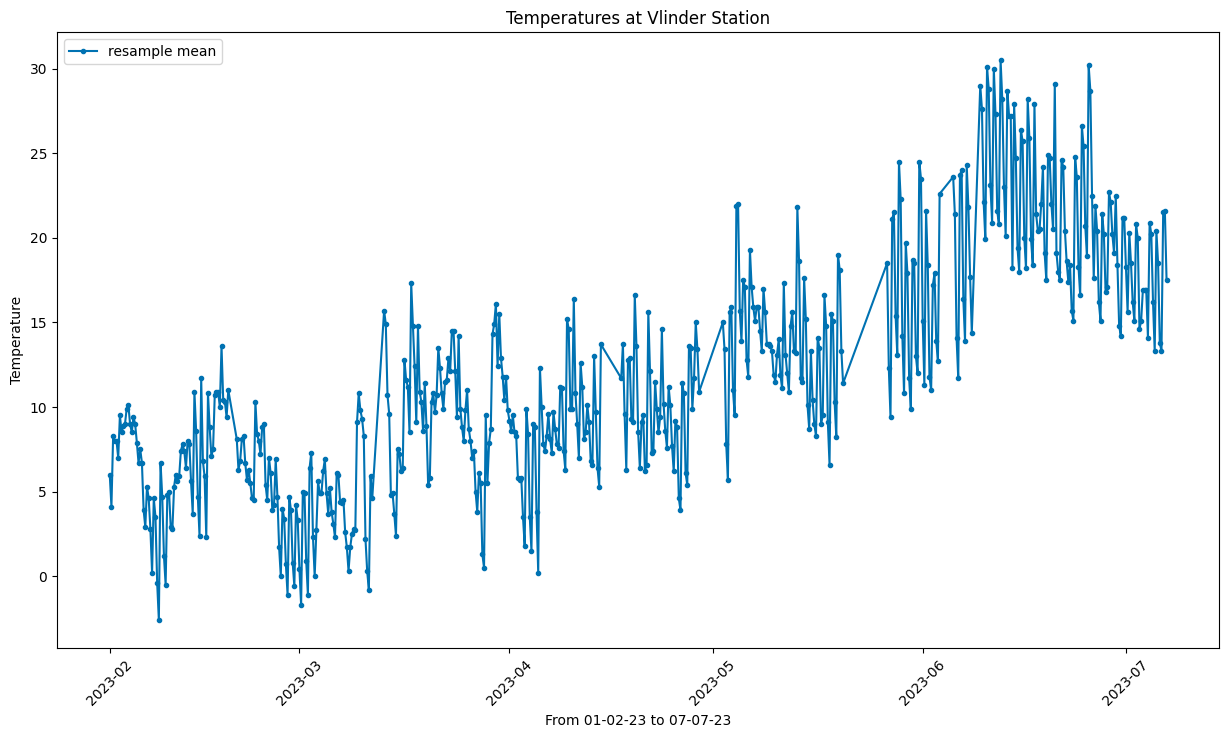

In [8]:
df = vlinder_data.resize_on_time("first", start=forecast_min, finish=forecast_max)
df = vlinder_data.drop_cst(df, 12)
vlinder_data.plot_one(df, info="resample mean")

Partial function application to select what vlinder data we should keep.

In [9]:
drop_const_p = partial(vlinder_data.drop_cst, max_delta=0)

## Integrating Forecast and Vlinder Temperaturs
1. We need to know how to resample our Vlinder Data.
   - Compute the mean of 't2m' (which will be our explanatory variable) and correlated it to the ressampled vlinder data. We then choose the highest correlated resampling method
2. We can then merge ensemble forecasts with observed vlinder data

### 1. Selection of resampling technique

We need to decide whether the mean or the first value is the right choice when resampling our Vlinder Data.
We compute correlation between the mean temperature (t2m) in the forecasts and the temperature at the vlinder station.

In [10]:
target = 't2m'

ensmean_forecast = forecast_data.get_df().groupby('time')[target].mean().reset_index()
ensmean_forecast[target] = ensmean_forecast[target] - Const_Conversion[target]
ensmean_forecast['time'] = pd.to_datetime(ensmean_forecast['time'])
ensmean_min, ensmean_max = forecast_data.get_min_max()

resize_vlinder = vlinder_data.apply_dates_resize(forecast_min, forecast_max)

dropped_vlinder_mean = drop_const_p(resize_vlinder("mean"))
dropped_vlinder_first = drop_const_p(resize_vlinder("first"))

merge_p = partial(pd.merge, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
merged_df = merge_p(ensmean_forecast, dropped_vlinder_mean).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'mean'})
merged_df = merge_p(merged_df, dropped_vlinder_first).drop(columns=[vlinder_data.time_str]).rename(columns={vlinder_data.temp_str: 'first'})

correlation_mean = merged_df['t2m'].corr(merged_df['mean'])
correlation_first = merged_df['t2m'].corr(merged_df['first'])

print(correlation_mean, correlation_first)

0.9480840831965944 0.976521388963622


We can see that resampling on first value found in the interval has a higher correlation with our main target value 't2m'. We will use this resampling technique from now on.

### 2 Merging ensemble forecasts and vlinder temperatures

We will keep all ensemble forecasts inside a list and not merge them directly inside a unique dataframe. This helps with visualization of data as well as making it easier to target individual ensemble forecasts. It also makes it more flexible to select certain dataframes in case we dont want them for some reason. This will come up handy later. We can easily do operations on those dataframes using list processing techniques such as map, reduce and partial application.

In [11]:
def create_ens_fc_list():
    """
        Creates a list of tuples containing (start_date : string, ensemble forecast: dataframe). 
        All ensemble forecast dataframes are augmented with the respective vlinder data.
        This means that some dataframes may contain less predictions as the corresponding vlinder measurement was unusable
    """
    # get list of starting dates of ensemble forecasts
    starting_dates = forecast_data.get_start_dates()
    
    # get corresponding vlinder data with constant values dropped as decided by drop_const_p
    vlinder_temp =  drop_const_p(resize_vlinder("first"))

    dfs = []
    for date in starting_dates:
        df = forecast_data.get_ensemble_forecast(date).reset_index()
        df[forecast_data.time_str] = pd.to_datetime(df[forecast_data.time_str])
        df = pd.merge(df, vlinder_temp, left_on=forecast_data.time_str, right_on=vlinder_data.time_str)
        df.drop(columns=vlinder_data.time_str, inplace=True)
        # We need to redefine date here as the inital date could be dropped because it does not exist in the vlinder set
        # This might create data frames with the same starting date.
        date = df['time'][0]
        # if a duplicate date exists we keep the dataframe which has the most elements
        current_dates = list(map(lambda tp: tp[0], dfs))
        if date in current_dates:
            index = current_dates.index(date)
            # if the current dataframe contains more info than the current one in the list
            if (len(df) > len(dfs[index][1])): 
                # we remove element at that index
                dfs.pop(index)
        
        dfs.append((date, df))
    
    return dfs


#Some utility functions use to handle list of tuples generated by previous function
def nb_observation(df):
    return len(df.index) // 50

def date_and_obs(tp):
    start, df = tp
    return (str(start), nb_observation(df))

def only_date(tp):
    date, _ = tp 
    return date

def only_df(tp):
    _, df = tp
    return df

def merge_df(df_1, df_2):
    """
        Merges two dataframes
    """
    combined_df = pd.concat([df_1, df_2], ignore_index=False)
    return combined_df

def reduce_df(dfs_list):
    """
        Reduces all dataframes from the input list into one
    """
    reduced_df = reduce(merge_df, map(only_df, dfs_list))
    return reduced_df

dfs = create_ens_fc_list();
#contains number of observation left for each time forecast
samples_per_fc = list(map(date_and_obs, dfs))
samples_per_fc

[('2023-02-01 00:00:00', 27),
 ('2023-02-03 00:00:00', 29),
 ('2023-02-05 00:00:00', 29),
 ('2023-02-07 00:00:00', 29),
 ('2023-02-10 00:00:00', 27),
 ('2023-02-13 00:00:00', 23),
 ('2023-02-15 00:00:00', 23),
 ('2023-02-17 06:00:00', 24),
 ('2023-02-20 00:00:00', 29),
 ('2023-02-22 00:00:00', 29),
 ('2023-02-25 00:00:00', 28),
 ('2023-02-27 00:00:00', 27),
 ('2023-03-01 00:00:00', 27),
 ('2023-03-02 00:00:00', 27),
 ('2023-03-03 00:00:00', 27),
 ('2023-03-07 00:00:00', 23),
 ('2023-03-10 00:00:00', 23),
 ('2023-03-13 12:00:00', 27),
 ('2023-03-15 00:00:00', 29),
 ('2023-03-17 00:00:00', 27),
 ('2023-03-19 00:00:00', 27),
 ('2023-03-22 00:00:00', 27),
 ('2023-03-25 00:00:00', 29),
 ('2023-03-28 00:00:00', 29),
 ('2023-03-30 00:00:00', 29),
 ('2023-04-03 00:00:00', 28),
 ('2023-04-05 00:00:00', 27),
 ('2023-04-08 00:00:00', 25),
 ('2023-04-10 12:00:00', 17),
 ('2023-04-13 00:00:00', 18),
 ('2023-04-17 12:00:00', 19),
 ('2023-04-18 00:00:00', 29),
 ('2023-04-20 00:00:00', 29),
 ('2023-04

Except for the forecast starting on `2023-05-20 00:00:00`, most of the forecast still have information left in them. We will remove this forecast as it does not give enough information to accurately depcit an ensemble forecast

In [12]:
#timestamp object of forecast that the least amount of info (here 4)
not_enough_info = pd.to_datetime(min(samples_per_fc, key=lambda x: x[1])[0])
not_enough_info

Timestamp('2023-05-20 00:00:00')

In [13]:
number_of_obs = reduce(lambda x, y: x + y, map(lambda tp : tp[1], samples_per_fc))
number_of_obs

1495

# Splitting Train, Validation and Test sets

As we want to train multiple models to see which has the best outcomes we want to split our data. We will do so by keeping ensemble forecasts together by starting date. Some ensemble forecast will be used to train the models, other to validate and a final ensemble forecast will be used to do the final assessment. 

However we might face data leakage if we do random splitting as we have overlapping forecasts. This means that the same target variable ('t2m') might end up in a training sample and in a test sample. We need to do further analysis to verify how our data behaves and what suitable splitting techniques are. We could either: 
- Drop all overlapping data so that each value is unique.
- Combine overlapping data in a mean value
- If variation in forecast and measurement are not dependend on time we could split on time periods, keeping forecasts together on time

Selected solution: as no pattern seems to appear with time we split the data chronologically (x first % go into train, following y% into validation and last z% into test set). We then remove overlapping values at each intersection to avoid data leakage. Selecting chronologically limits
the number of overlapping values we need to drop

## Analysis of relation between target temperature and ensemble forecasts

We will first analyse the difference between the measured temperature at the vlinder station and the t2m variable (=relative error) to see if there are any difference thourghout the year. Does the forecast overshoot or undershoot the measured data depending on season of the year?
This will help select the right way of splitting our data (if no patterns appear throughout the year, we can split chronologically)

This analysis will also help to remove outliers in our data. We will find relative errors with abnormal variance/mean.

### 1. Analysis of relative error between forecast and measured temperature

We compute the difference between ensemble forecast mean for each timestamp and the measured temperature at that timestamp.

In [14]:
df_diff = create_ens_fc_list()

def keep_columns(to_keep, df):    
    return df[to_keep]

def group_time(df):
    mean_fc = df.groupby('time').mean()
    mean_fc['t2m'] = mean_fc['t2m'] - C_0
    return mean_fc

def diff_tm2_tmp(df):
    df['diff'] = df['t2m'] - df['temp']
    return df

def create_mean(df):
    """
        Creates column holding mean of difference 
        Requires that diff column has already been computed
    """
    df['mean_diff'] = df['diff'].mean()
    return df

keep_cols = partial(keep_columns, ['time', 't2m', 'temp'])

operations = compose(create_mean, diff_tm2_tmp, group_time, keep_cols, only_df)

list_df_diff = list(map(operations, df_diff))

In [15]:
# def plot_lst(df_lst, on='diff', ylabel='Temperature Delta (t2m - obs)', title="Relative error between forecast ensmean and observed temperature"):
#     """
#         Plots all dataframes in list given as argument on parameter passed as argument
#     """
#     plt.figure(figsize=(10, 5))
#     plt.axhline(0, color='black', linestyle='--')
#     for df in df_lst:
#         start = df.index[0]
#         df = df.reset_index()
#         plt.plot(df[forecast_data.time_str], df[on], label=start)
#     plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.2), ncols=6)
#     plt.ylabel(ylabel)
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.show()

# plot_lst(list_df_diff[: len(list_df_diff) // 2])
# plot_lst(list_df_diff[len(list_df_diff) // 2 :])

NOTE: Comment above commented function above, not readable with that much data. Not needed atm but kept in case, code might come handy later.

For each forecast we will compute the mean and the variance of the relative error. This will show extreme values we can then remove. We will also verify if there are trends on a seasonal basis, this will help to split the data into different splits later.

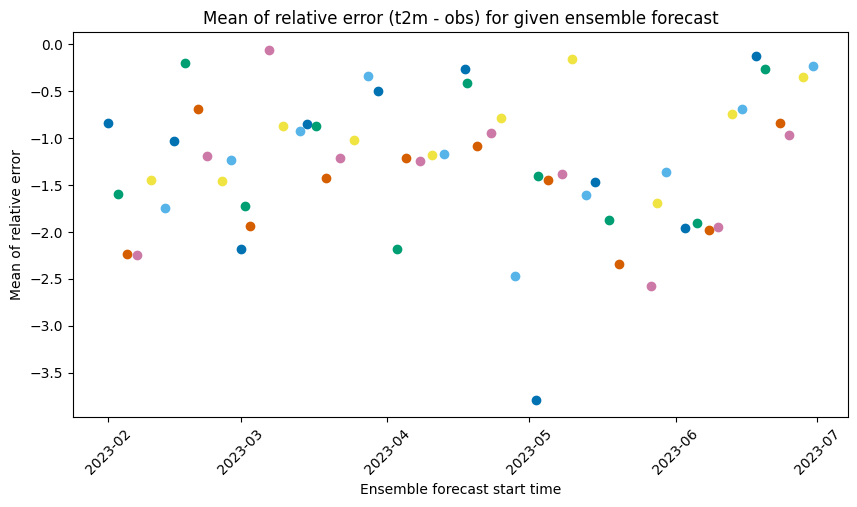

In [16]:
def compute_variance(target, df):
    """
        Computes variance on columns for given dataframe
    """
    df[f'{target} var'] = df[target].var()
    return df

def scatter_list_var(df_lst, on='diff var', ylabel='missing label', title="missing title"):
    """
        Plots all dataframes in list given as argument on parameter passed as argument
    """
    
    plt.figure(figsize=(10, 5))
    for df in df_lst:
        start = df.index[0]
        df = df.reset_index()
        plt.scatter(df[forecast_data.time_str], df[on].values, label=start)
    #plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.20), ncols=6)
    plt.ylabel(ylabel)
    plt.xlabel('Ensemble forecast start time')

    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

scatter_list_var(list(map(lambda df : df.iloc[[0]], list_df_diff)), on='mean_diff', ylabel='Mean of relative error', title='Mean of relative error (t2m - obs) for given ensemble forecast')



Relative error mean seems quite constant during the year. We can see that our relative error is always negative, this means that obs > t2m, which means that our ensemble forecast tends to predict lower temperatures than those that are measured.

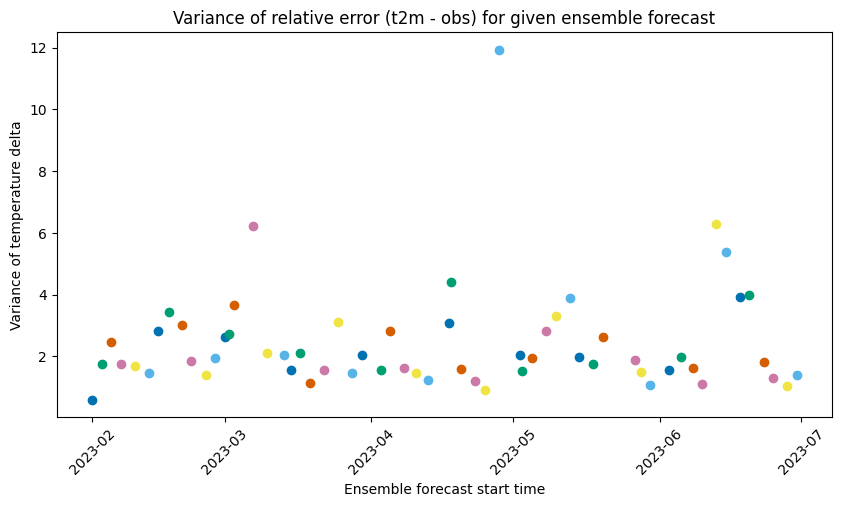

In [17]:
compute_variance_diff = partial(compute_variance, 'diff')

list_df_var = list(map(compute_variance_diff, list_df_diff))
#selects only first occurence for each ensemble forecast
diff_var_first = list(map(lambda df : df.iloc[[0]], list_df_var))
scatter_list_var(diff_var_first, on='diff var', ylabel='Variance of temperature delta',  title='Variance of relative error (t2m - obs) for given ensemble forecast')

Mean and variance are looking quite constant and do not dependend on season. 
There are however a few outliers, one sample seems to be especially cold and anothers seems to have high variance (above 4). We will plot those values onto histograms to make it appear more clearly.

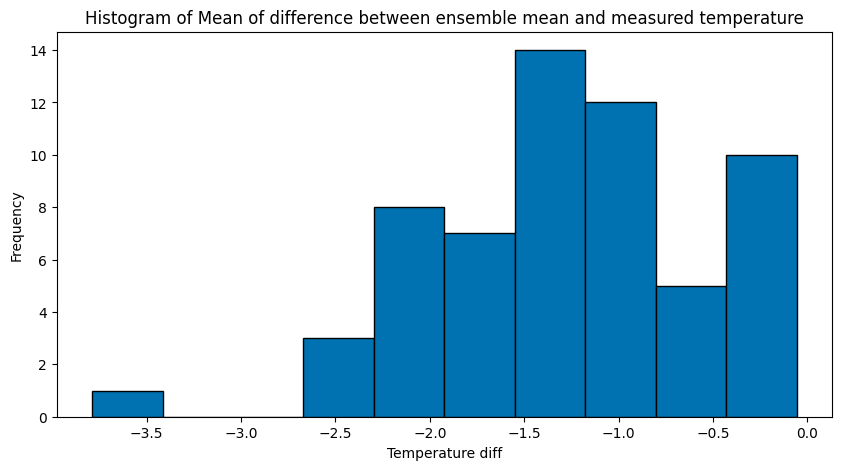

In [18]:
diff_mean = reduce(merge_df, list(map(lambda df : df.iloc[[0]], list_df_var)))

plt.figure(figsize=(10, 5))
plt.hist(diff_mean['mean_diff'], bins=10, edgecolor='black')
plt.xlabel('Temperature diff')
plt.ylabel('Frequency')
plt.title('Histogram of Mean of difference between ensemble mean and measured temperature')
plt.show()

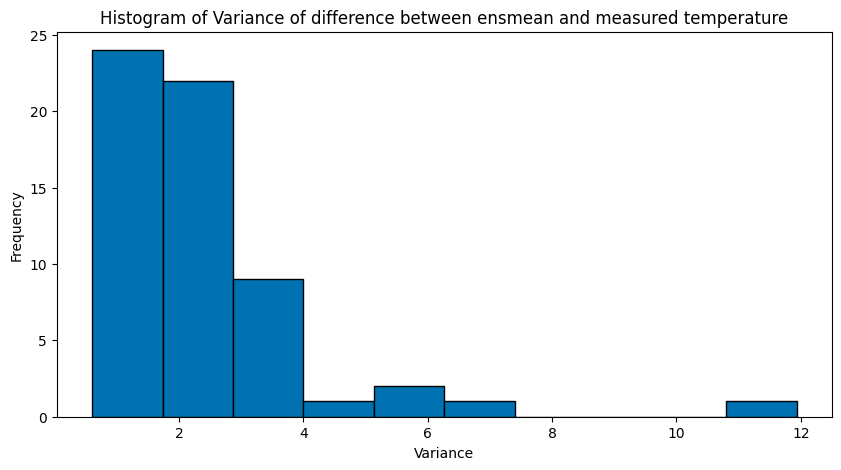

In [19]:
diff_var = reduce(merge_df, diff_var_first)

plt.figure(figsize=(10, 5))
plt.hist(diff_var['diff var'], bins=10, edgecolor='black') # Adjust bins as needed
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Variance of difference between ensmean and measured temperature')
plt.show()

We have few high variance ensemble forecasts. We will arbitrarily remove those with a variance higher than 4. We also have one forecast with mean temperature -3.5. Those are outliers that will be dropped.
We should try to predict distribution and then do some hypothesis testing to remove outliers more mathematically.

In [20]:
high_variance = diff_var[diff_var['diff var'] > 4].index.to_list()
high_mean = diff_mean[diff_mean['mean_diff'] < - 3].index.to_list()

outliers = list(set(high_variance + high_mean))
outliers

[Timestamp('2023-05-02 12:00:00'),
 Timestamp('2023-06-15 00:00:00'),
 Timestamp('2023-03-07 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-04-18 00:00:00'),
 Timestamp('2023-06-13 00:00:00')]

In [21]:
# #from https://stackoverflow.com/questions/37487830/how-to-find-probability-distribution-and-parameters-for-real-data-python-3
# import scipy.stats as st
# from scipy.stats import pareto, kstest

# def get_best_distribution(data):
#     dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
#     dist_results = []
#     params = {}
#     for dist_name in dist_names:
#         dist = getattr(st, dist_name)
#         param = dist.fit(data)

#         params[dist_name] = param
#         # Applying the Kolmogorov-Smirnov test
#         D, p = st.kstest(data, dist_name, args=param)
#         print("p value for "+dist_name+" = "+str(p))
#         dist_results.append((dist_name, p))

#     # select the best fitted distribution
#     best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
#     # store the name of the best fit and its p value

#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))

#     return best_dist, best_p, params[best_dist]

# _, _, params = get_best_distribution(tmp['diff var'].values)

In [22]:
dfs = create_ens_fc_list()

to_remove = outliers + [not_enough_info]
#to_remove = []

tmp = list(map(lambda x: x[0], samples_per_fc))


my_list = list(map(lambda x: x[0], dfs))

"""
    In the ensemble forecast list (dfs), tp[0] are timestamp objects, not strings => to_remove list should contain
    timestamp objects
"""

cleared = list(filter(lambda tp : tp[0] not in to_remove, dfs))

assert len(cleared) + len(to_remove) == len(dfs), f"cleared list + remove list is not the same length as inital list: {len(cleared)} + {len(to_remove)} != {len(dfs)}"

def select_chronologically(dfs_list, train_p=0.6, val_p=0.2):
    """
        Selects in order of appearance: first 'train_p'% values are going into train set, following `val_p`% are going into train set 
        and rest goes into test set
        Might not be exatly split as some dataframe contain different number of observations after data cleaning
        TODO: We have a lot of overlapping data in the beggining (from 1-03 to 3-03), is this an issue?
    """
    nb_elem = len(dfs_list)
    train_index_max = int(nb_elem * train_p)
    
    train_set = dfs_list[: train_index_max]
    
    val_index_max = int(nb_elem * (train_p + val_p))
    val_set = dfs_list[train_index_max: val_index_max]
    
    test_set = dfs_list[val_index_max:]

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, val_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"

    return (train_set,val_set,test_set)

def select_randomly(dfs_list, train_p=0.6, val_p=0.2):
    """
        Splits randomly values from from given input dataframe list into (train_set, val_set, test_set)
        TODO: might not be exatly as dataframe contain different number of observations after data cleaning
        NOTE: not used anyway
    """
    nb_elem = len(dfs_list)
    
    nb_train_elements = int(nb_elem * train_p)
    train_set = sorted(random.sample(dfs_list, nb_train_elements), key=lambda x : x[0])

    #list of not selected elements
    rest = sorted([tp for tp in dfs if tp not in train_set], key=lambda x : x[0])

    nb_val_elements = round(nb_elem * val_p)
    
    validation_set = sorted(random.sample(rest, nb_val_elements), key=lambda x : x[0])

    test_set = sorted([tp for tp in rest if tp not in validation_set], key=lambda x : x[0])

    contains_common_elements = set(map(only_date, train_set)) & set(map(only_date, validation_set)) & set(map(only_date, test_set))
    assert not contains_common_elements, "train, validation and test contain same ensemble forecast"
    return (train_set, validation_set, test_set)

def get_unique_timestamps_set(df_list):
    """
        returns set of all timestamps of the list of dataframe passed as argument
    """
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    return set(reduce(operator.concat, list(map(operations, df_list))))

def select_unique(dfs_list, train_p=0.6, val_p=0.2): 
    """
        We need to make sure that no common dates are appearing in train, validation and test set
        1. extract all unique time stamps from train, validation and test set
        2. As we select chornologically we need to check only if there is overlapping data between train-val and val-test
        3. Remove overlapping data from the earliest dataframe, (=> from train in train-val and from val in val-test). 
            -> This favors that is a bit more recent in the 
    """
    train, val, test = select_chronologically(dfs_list, train_p, val_p)
    operations = compose(lambda np_arr: np_arr.tolist(), lambda df: df['time'].unique(), only_df)
    
    #list containing sublists with all unique time stamps within a given dataframe
    unique_dates_train = get_unique_timestamps_set(train)
    uniques_dates_val = get_unique_timestamps_set(val)
    uniques_dates_test = get_unique_timestamps_set(test)

    conflict_train_val = unique_dates_train & uniques_dates_val
    conflict_val_test = uniques_dates_val & uniques_dates_test
    
    # Removes conflicting values from train and validation sets
    train = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_train_val))]), train))
    val = list(map(lambda tp: (tp[0], tp[1][~tp[1]['time'].isin(list(conflict_val_test))]), val))
    
    return (train, val, test)

train_set, val_set, test_set = select_unique(cleared)

unique_dates_train = get_unique_timestamps_set(train_set)
unique_dates_val = get_unique_timestamps_set(val_set)
unique_dates_test = get_unique_timestamps_set(test_set)

# making sure that no timestamp exists in muliple sets
assert len(cleared) == len(train_set) + len(val_set) + len(test_set), f"Inital list and sum of generated list do not have the same number of elements {len(cleared)} != {len(train_set)} + {len(val_set)} + {len(test_set)}"
assert len(unique_dates_train & unique_dates_val) == 0, f"Train and validation sets contain same dates {unique_dates_train & unique_dates_val}"
assert len(unique_dates_val & unique_dates_test) == 0, f"Val and Test sets contain same dates {unique_dates_val & unique_dates_test}"
assert len(unique_dates_train & unique_dates_test) == 0, f"Train and Test sets contain same dates {unique_dates_train & unique_dates_test}"


### Dependencies Analysis

As our data is now merged, we will analyze dependencies between our feature variables (from the ensemble forecast) and our target variables (observed vlinder temperature)

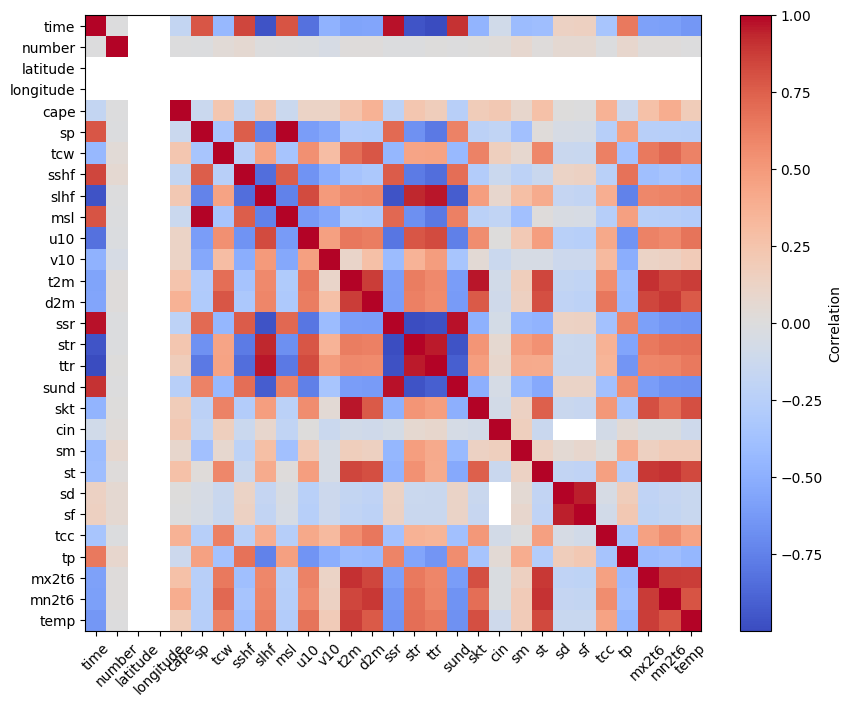

In [23]:
def display_corr_matrix(df):
    corr_matrix = df.corr() 
    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest') 
    plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
    plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
    plt.colorbar(label='Correlation')
    plt.show()
df_1 = train_set[0][1]

display_corr_matrix(df_1)

(39900, 29)


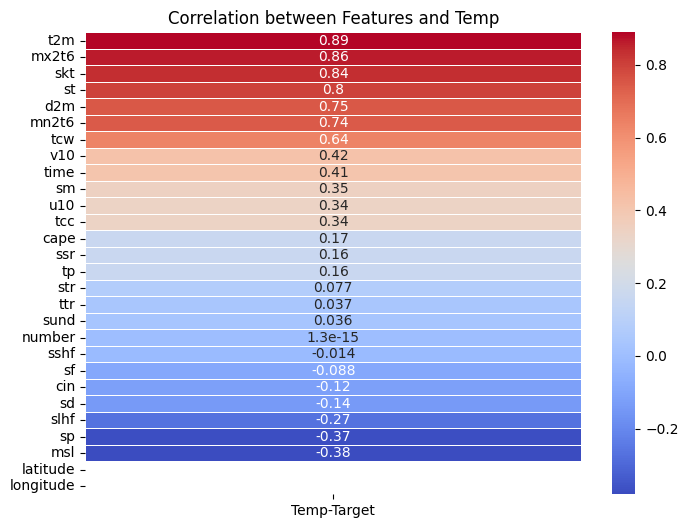

In [24]:
import seaborn as sns
complete_df = reduce_df(train_set)

complete_df['temp'] = complete_df['temp'] + C_0

# Code stolen from Bektas :))
print(complete_df.shape)
correlations = complete_df.corr()['temp'].sort_values(ascending=False).drop('temp')

# Create a DataFrame to hold the correlation values
temp_corr_df = pd.DataFrame({'Temp-Target': correlations})

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(temp_corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Features and Temp')
plt.show()

Without surprise we can see from the correlation matrix that the features from the ensemble forecast that are highly correlated with the vlinder temperature are those measuring some kind of temperature (skt, t2m, d2m, mx2t6, mn2t6,..). 
But those features are also heavily correlated with each other as they represent the same thing. They therefore might not convey usefull additional information.

Having correlated features is called Multicollinearity. 

Having multicollinearity is an issue for certain ml models, and not for others. However removing multicollinearity helps with explanability of our models. (https://hackernoon.com/multicollinearity-and-its-importance-in-machine-learning).
We could use models

The first non temperature related temperature is `tcw` (= total column water)

Latitude and longitude are constant values that hold no explicative power, we will drop them later

We also need to check for NaN values.

In [25]:
#Display columns that have NaN values and percentage of NaN values
def nan_info(df):
    for column in which_col_nan(df):
        nan_percent = get_nan_percent(df[column], df.shape[0])
        print(f"{column} has {nan_percent * 100:.2f} % of NaN values" )
        
#Returns list of Columns that have nan values
def which_col_nan(df):
    return df.columns[df.isna().any()].tolist()

def get_nan_percent(df_col, df_entries):
    return df_col.isna().sum() / df_entries

nan_info(complete_df)

cin has 88.88 % of NaN values
mx2t6 has 3.38 % of NaN values
mn2t6 has 3.38 % of NaN values


We can see that cin has a large amount of NaN values and mx2t6 and mn2t6 have smaller amount, we will definitevely drop cin, but we could extrapolate mx2t6 it appears to be interesting.

Most of the values are actually not really relevant and our models will mainly focus on `t2m` feature

In [26]:
# Returns list of columns who have a number of unique features = 1 (=> all the same values)
# from https://studymachinelearning.com/pandas-how-to-remove-dataframe-columns-with-constant-same-values/
def constant_value_features_columns(df):
    return [e for e in df.columns if df[e].nunique() == 1]

def remove_cst_values(df):
    to_keep = [e for e in df.columns if e not in constant_value_features_columns(df)]
    return df[to_keep]

def remove_nan_values(df):
    na_cols = which_col_nan(df)
    return df.drop(columns=na_cols, axis=1)

def clean_dfs(df_lst):
    """ 
        Takes in a LIST of [(timestamp, dataframes)]
        Applies above mentionned transformations to a list of dataframes
            - Removes columns with all const values
            - Removes columns with NaN values
        Returns only one dataframe 
    """
    reduce_merge_train = reduce(merge_df, map(only_df, df_lst))
    return clean_one(reduce_merge_train)

def clean_one(df):
    """
        Takes in a dataframe, applies transformations
        - Removes columns with all const values
        - Removes columns with NaN values
        Returns cleaned dataframe
    """
    transform_operations = compose(remove_cst_values, remove_nan_values)
    cleaned_df = transform_operations(df)
    return cleaned_df

Those clean functions are not really usefull in practice as we will mostly select features that are always complete and not constant.

# Training Models

For each model we will:
1. Clean and transform the train data to prepare it for the model
3. Fit the model
4. Try the model on validation data.
    - We might need to transform validation data aswell
    - Compute the corrected forecast values and and take the mean. We can then compare this mean to our measured temperature on the same interval

In [27]:
model_list = []

We will store all models as tuples ("modelname", model, transform function) inside the model_list.
This is done to make it easier later to evaluate the different models

## Linear Regression
"Least-squares regression is applied on training data to estimate a linear relationship between predictions and corresponding observations" from _Vannitsem, S., Wilks, D. S., & Messner, J. W. (Elsevier). (2018). Statistical Postprocessing of Ensemble Forecasts_

We will first fit a linear regression with only 't2m' as a feature.

We will then make a second linear regression with 't2m' and 'tcw' as its the second highest correlated value that is not a temperature.

### 1. Only t2m feature

In [28]:
def transform_df_lr_lst(df_list):
    """
        Applies specific transformation operations to process list of dataframes, either for training, validation or testing
    """
    df = reduce_df(df_list)
    df = df[['t2m', 'temp', 'time']]
    #We group on time and t2m is the mean of the ensemble forecast
    #If we have multiple forecasts for the same date we have the mean of all those forecats
    #We could build a model where we only keep the latests date, might improve short term prediction
    df = df.groupby('time').mean()
    #keep everything in Kelvin as it is the target
    df['temp'] = df['temp'] + C_0
    return df

def transform_df_lr_fc(df):
    """
        Creates numpy array to be fed to model.fit function from dataframe 
    """    
    return df['t2m'].values.reshape(-1, 1)

df_train = transform_df_lr_lst(train_set)

In [29]:
X_train = df_train['t2m'].values.reshape(-1, 1)
y_train = df_train['temp'].values.reshape(-1, 1)

In [30]:
#@track_emissions()
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

linear_regression = train_model(LinearRegression(), X_train, y_train)
#append our model to the list
model_list.append(("Linear regression base", linear_regression, transform_df_lr_fc))

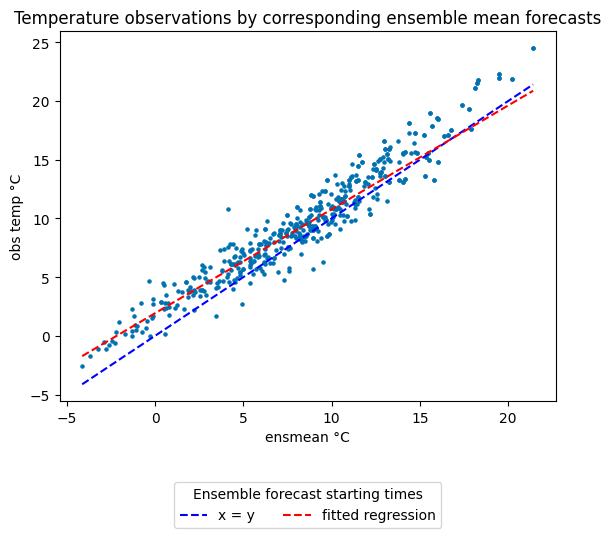

In [31]:
display = pd.concat([transform_df_lr_lst(train_set), transform_df_lr_lst(val_set), transform_df_lr_lst(val_set)])

x = np.linspace(min(display['t2m'] - C_0), max(display['t2m'] - C_0))
y = x

slope = linear_regression.coef_[0]
intercept = linear_regression.intercept_

line = slope * np.linspace(min(display['t2m']), max(display['t2m'])) + intercept - C_0

plt.scatter(display['t2m'] - C_0, display['temp'] - C_0, marker='o', s=5)
plt.plot(x , y, linestyle='--', color='blue', label='x = y')
plt.plot(x , line, linestyle='--', color='red', label='fitted regression')
plt.legend(title="Ensemble forecast starting times", loc='upper center', bbox_to_anchor=(0.5, -0.20), ncols=6)
plt.xlabel("ensmean °C")
plt.ylabel("obs temp °C")
plt.title('Temperature observations by corresponding ensemble mean forecasts')
plt.show()

We can actually see that our linear regression is going to perform quite poorly when temperatures are higher than 5 degrees and is going to do barely better than the ensemble mean. This might because there is a higher temperature difference at lower temperatures (probably at night) which makes our regression tilt to the right. We will try to reduce this bias by trying other regression techniques such as Ridge and Lasso.

In [32]:
print((display['temp'] - display['t2m']).mean())

1.256812949580816


### 1. t2m and tcw

In [33]:
def transform_df_lr2_lst(df_list):
    """
        Applies specific transformation operations to process list of dataframes, either for training, validation or testing
    """
    df = reduce_df(df_list)
    df = df[['t2m', 'tcw', 'temp', 'time']]
    df = df.groupby('time').mean()
    #keep everything in Kelvin as it is the target
    df['temp'] = df['temp'] + C_0
    return df

def transform_df_lr2_fc(df):
    """
        Creates numpy array to be fed to model.fit function from dataframe 
    """    
    return df[['t2m', 'tcw']].values

df_train = transform_df_lr2_lst(train_set)

X_train = df_train[['t2m', 'tcw']].values
y_train = df_train['temp'].values.reshape(-1, 1)

#@track_emissions()
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model


linear_regression2 = train_model(LinearRegression(), X_train, y_train)
#append our model to the list
model_list.append(("Linear regression t2m tcw", linear_regression2, transform_df_lr2_fc))

## Ridge regression and Lasso

https://www.ibm.com/topics/ridge-regression

As mentionned before, most of the values that have a high correlation with target temperature are also correlated with each other. In order to reduce this multicollinearity we can use regularization to improve our forecast.

We can either use Ridge or Lasso.

Ridge (=L2) will shrink down certain extreme values (but they wont be equal to 0 -> there is no feature selection).

Lasso (=L1) will reduce certain features to 0 and thus perform selection. 

In [34]:
def transform_df_ridge_lst(df_list):
    """
        Applies specific transformation operations to process list of dataframes, either for training, validation or testing
    """
    df = reduce_df(df_list)

    df = df[['t2m', 'tcw', 'st', 'skt', 'd2m', 'temp', 'time']]
    df = df.groupby('time').mean()
    #keep everything in Kelvin as it is the target
    df['temp'] = df['temp'] + C_0
    return df


def transform_df_fc_features(features_list, df):
    """
        Selects all features from feature_list from dataframe and creates data in the right form
        to be processed by randomForst.predict
    """
    df = df[['t2m', 'tcw', 'st', 'skt', 'd2m']]
    return df.values


## Ridge
df_train_ridge = transform_df_ridge_lst(train_set)

X_train = df_train_ridge[['t2m', 'tcw', 'st', 'skt', 'd2m']].values
y_train = df_train_ridge['temp'].values.reshape(-1, 1)

ridge = Ridge()
param_grid = {'alpha': [0.1, 1.0, 10.0], 'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

grid_search = GridSearchCV(ridge, param_grid, cv=5)

grid_search.fit(X_train, y_train)
ridge = grid_search.best_estimator_

partial_transform_ridge = partial(transform_df_fc_features, ['t2m', 'tcw', 'st', 'skt', 'd2m'])

model_list.append(('Ridge', ridge, partial_transform_ridge))

## Lasso
lasso = Lasso()
param_grid = {'alpha': [0.1, 1.0, 10.0], 'selection': ['cyclic', 'random']}
grid_search = GridSearchCV(lasso, param_grid, cv=5)
grid_search.fit(X_train, y_train)
lasso = grid_search.best_estimator_
#can use the same function as for ridge
model_list.append(('Lasso', lasso, partial_transform_ridge))

## Random Forest Regression

In order to display information during hyperparameter tuning (displaying the diminishing returns of n_estimators) we will need an independent set, we will thus remove one of the forecasts from the train set.

#TODO: Try out by using ensemble forecast mean instead of taking all the values.

In [35]:
random_forest_train = reduce_df(train_set).groupby('time').mean().reset_index()

y_train_rf = random_forest_train[['temp']] + C_0
X_train_rf = random_forest_train.drop(columns=['temp', 'time'])
X_train_rf = clean_one(X_train_rf)

In [36]:
from sklearn.feature_selection import SelectKBest, f_regression

#should check by also adding tcw as a value
selector = SelectKBest(k=1, score_func=f_regression)
X_selected = selector.fit_transform(X_train_rf, y_train_rf.values.ravel())
cols_idxs = selector.get_support(indices=True)
X_train_rf = X_train_rf.iloc[:,cols_idxs].reset_index().drop(columns='index')

rf_selected_features = X_train_rf.columns.to_list()
print(rf_selected_features)

['t2m']


We create a baseline random forest regressor. We will use this base line regressor to compare to tuned random forest

In [37]:
#fit baseline RF
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_rf.values, y_train_rf['temp'].values.reshape(-1, 1).ravel());

In [38]:
#from https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
# Get numerical feature importances
importances = list(rf_base.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(rf_selected_features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: t2m                  Importance: 1.0


When selecting K = 5

```
Variable: t2m                  Importance: 0.81
Variable: st                   Importance: 0.06
Variable: tcw                  Importance: 0.05
Variable: d2m                  Importance: 0.04
Variable: skt                  Importance: 0.04
```
We can see that the most importante variable is clearly t2m. Furthermore, the model does way better when select k = 1 (only t2m) as feature

In [39]:
def transform_df_rf_fc(features_list, df):
    """
        Selects all features from feature_list from dataframe and creates data in the right form
        to be processed by randomForst.predict
    """
    df = df[features_list]
    return df.values

In [40]:
partial_transform_df_rf = partial(transform_df_rf_fc, rf_selected_features)
model_list.append(("Base random forest", rf_base, partial_transform_df_rf))

We will start doing hyper paramter tuning here. 

In [41]:
#Work in progress
#from https://stackoverflow.com/questions/60768008/how-to-choose-n-estimators-in-randomforestclassifier

# y_test = additional_set[1]['temp']
# x_test = partial_transform_df_rf(additional_set[1])

# scores =[]
# for k in range(1, 100):
#     rfr = RandomForestRegressor(n_estimators=k)
#     rfr.fit(X_train_rf.values, y_train_rf['temp'].values.reshape(-1, 1).ravel())
#     y_pred = rfr.predict(x_test)
#     mse = mean_squared_error(y_test, y_pred)
#     scores.append(mse)

# # plot the relationship between K and testing accurac
# # plt.plot(x_axis, y_axis)
# plt.plot(range(1, 100), scores)
# plt.xlabel('Value of n_estimators for Random Forest Classifier')
# plt.ylabel('Testing Accuracy')

We first start by doing a randomSearch, this gives a general hint to what our parameters could be. We will then do a gridsearch to make a more exhaustive search.

In [42]:

@track_emissions
@timer
def randomSearch(x_train, y_train):
    """
        Used to get a rough estimate of what our hyper parameters should look like
        This function takes too much time, we might want to reduce train values
    """
    #from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    # nb of trees in the forest, the more the better, there is nothing restricting use to add more, this will incrementaly slow down our code.
    n_estimators = [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
    max_features = ['log2', 'sqrt', 1.0]
    # max depth of the tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    # if depth is None: nodes are expanded or until leaves contain less than min samples split
    max_depth.append(None)
    # min number of samples to split a node
    min_samples_split = [2, 5, 10, 100, 1000]
    # min number of samples to be a leaf node
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf, 
                   'bootstrap': bootstrap}
    
    rf_regressor = RandomForestRegressor()
    
    rf_random = RandomizedSearchCV(estimator = rf_regressor, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
    
    rf_random.fit(x_train, y_train.values.ravel())
    return rf_random.best_params_

#params selected here will also depend on the k best selected params earlier
random_best_params = randomSearch(X_train_rf, y_train_rf)
random_best_params

[codecarbon INFO @ 21:20:31] [setup] RAM Tracking...
[codecarbon INFO @ 21:20:31] [setup] GPU Tracking...
[codecarbon INFO @ 21:20:31] No GPU found.
[codecarbon INFO @ 21:20:31] [setup] CPU Tracking...
[codecarbon WARNING @ 21:20:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:20:31] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 21:20:31] >>> Tracker's metadata:
[codecarbon INFO @ 21:20:31]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 21:20:31]   Python version: 3.11.7
[codecarbon INFO @ 21:20:31]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 21:20:31]   Available RAM : 8.000 GB
[codecarbon INFO @ 21:20:31]   CPU count: 8
[codecarbon INFO @ 21:20:31]   CPU model: Apple M1
[codecarbon INFO @ 21:20:31]   GPU count: None
[codecarbon INFO @ 21:20:31]   GPU model: None
[codecarbon INFO @ 21:20:37] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 21:20:37

Finished randomSearch() in 2.6712 secs for 293 elements


{'n_estimators': 89,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 1.0,
 'max_depth': 20,
 'bootstrap': True}

We got a better idea what our hyperparameters should look like, instead of doing it randomly now we will try to improve it a bit more by doing a GridSearch

In [43]:
@track_emissions
@timer
def gridSearch(x_train, y_train):
    param_grid = {
        'bootstrap': [True],
        'max_depth': [20, 30, 40],
        'max_features': [1, 2, 3],
        'min_samples_leaf': [1, 2, 3, 4, 5],
        'min_samples_split': [80, 100, 120],
        'n_estimators': [30, 45, 60]
    }
    
    rf = RandomForestRegressor()
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)
    grid_search.fit(x_train, y_train)
    return grid_search

rf_tuned = gridSearch(X_train_rf, y_train_rf.values.ravel());
rf_tuned.best_params_

[codecarbon INFO @ 21:20:37] [setup] RAM Tracking...
[codecarbon INFO @ 21:20:37] [setup] GPU Tracking...
[codecarbon INFO @ 21:20:37] No GPU found.
[codecarbon INFO @ 21:20:37] [setup] CPU Tracking...
[codecarbon WARNING @ 21:20:37] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:20:37] CPU Model on constant consumption mode: Apple M1
[codecarbon INFO @ 21:20:37] >>> Tracker's metadata:
[codecarbon INFO @ 21:20:37]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 21:20:37]   Python version: 3.11.7
[codecarbon INFO @ 21:20:37]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 21:20:37]   Available RAM : 8.000 GB
[codecarbon INFO @ 21:20:37]   CPU count: 8
[codecarbon INFO @ 21:20:37]   CPU model: Apple M1
[codecarbon INFO @ 21:20:37]   GPU count: None
[codecarbon INFO @ 21:20:37]   GPU model: None
[codecarbon INFO @ 21:20:43] 
Graceful stopping: collecting and writing information.
Please wait a few seconds...
[codecarbon INFO @ 21:20:43

Finished gridSearch() in 4.6284 secs for 293 elements


{'bootstrap': True,
 'max_depth': 40,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 80,
 'n_estimators': 30}

In [44]:
#model_list.append(("rf best",rf_tuned, partial_transform_df_rf))

# Comparing different Models Part 1

In [48]:
def correct_forecast(df_to_correct, model, transform_func):
    """
        Takes in dataframe to correct (non processed), model to use for correction and function that corrects the dataframe to be fed to the model
        Returns corrected ensemble t2m values for given forecast.
        Should save target
        Returns input dataframe with corrected 't2m' values
    """
    #TODO : transform_func could be a function within a class and we pass just the the class in
    x = transform_func(df_to_correct)
    y = model.predict(x)

    corrected = df_to_correct.copy()
    corrected['t2m'] = y

    return corrected

In [130]:
from sklearn.metrics import mean_absolute_percentage_error

def get_measure(corr_val, target_val):
    """
        Returns mean squared error and determination coefficient between 
        the corrected values and the target value
    """
    corrected_mean = corr_val.mean(axis=1)
    y_val = target_val.groupby('time').mean() + C_0

    mse = mean_squared_error(y_val, corrected_mean)
    r2_s = r2_score(y_val, corrected_mean)
    return (mse, r2_s)


def correct_fc_list(df_list, model, transform_func):
    """
        From input list of dataframes, returns (original_df_list, measured_df_list, corrected_df_list) where 
            - original_df_list is a list of dataframes with original 't2m' values (from ensemble forecast)
            - measured_df_list is a list of dataframes with measured 'temp' metric (from vlinder)
            - corrected_df_list is a list of dataframes where 't2m' has been corrected with model given as param.
    """
    corr_fc_lst = []
    measured_lst = []
    original_lst = []

    # Selects each dataframe from validation set, saves target temperatures and computes corrected forecast
    for elem in val_set:
        df_val = elem[1]
        original_lst.append(df_val[['time', 't2m']])
        measured_lst.append(df_val[['time', 'temp']])
        corr_fc_lst.append(correct_forecast(df_val, model, transform_func))
    
    return (original_lst, measured_lst, corr_fc_lst)

def fill_nan(lst, mask):
    """
        Fills array with nan where mask == False, else keeps value from lst
    """
    i = 0
    j = 0
    result = []
    while i != len(mask):
        if mask[i] == True:
            result.append(lst[j])
            j += 1
        else: 
            result.append(np.nan) 
        i += 1
    assert len(result) == len(mask)
    return result
    
def correct_display(df_list, model, transform_func, desc):
    """
        Outputs graph with original forecast, corrected forecast and measured temperature 
        Computing mse and r2_s for each sample and then computing mean of those scores.
    """
    original, measured, corrected = correct_fc_list(df_list, model, transform_func)

    
    assert len(corrected) == len(measured), "List of corrected forecast and measured forecasts dont have the same lenght"
    nb_of_samples = len(corrected)
    fig, ax = plt.subplots(nb_of_samples, figsize=(15, 50))
    
    mse_list = []
    r2_s_list = []
    
    base_list = np.array([])
    errors_list = np.array([])
    
    for i in range(0, nb_of_samples):
        corr_df = corrected[i][['number', 'time', 't2m']]
        corr_df = corr_df.pivot(index='time', columns='number', values='t2m')
        
        measured_df = measured[i]
        original_df = original[i]

        #all those should be simple arrays
        corrected_mean = corr_df.mean(axis=1).values
        corrected_min = corr_df.min(axis=1).values
        corrected_max = corr_df.max(axis=1).values
        
        original_mean = (original_df.groupby('time').mean()).values.flatten()
        measured_temp = (measured_df.groupby('time').mean() + C_0).values.flatten()

        baseline = abs(measured_temp - original_mean)
        errors = abs(corrected_mean - original_mean)

        base_list = np.append(base_list, baseline)
        errors_list = np.append(errors_list, errors)

        #Need to get measures first before adding nan values
        mse, r2_s = get_measure(corr_df, measured_df)

        mse_list.append(mse)
        r2_s_list.append(r2_s)
        
        start = corr_df.reset_index()['time'].min()
        end = corr_df.reset_index()['time'].max()

        #All 6hours intervals between start and end
        total_time_period = (end - start) / pd.Timedelta(hours=6)
        hours =  np.arange(0, 6 * total_time_period + 1, 6)

        #all measurement periods in forecast
        time_stamp_list = corr_df.reset_index()['time'].values
        
        # difference between each time stamp in ns, converted into hours
        # #!!This will hold one less value as time_stamp_list as we compute the difference between first and second term
        diff_stamp = list(map(operator.sub, time_stamp_list[1:], time_stamp_list[:])) / np.timedelta64(1, 'h')

        #holds time stamps from corrected dataframe
        cumul_sum_stamp = [0] + list(accumulate(diff_stamp))
        #Array that holds true if observation is present for some a 6h interval, false otherwise
        mask = [True if x in cumul_sum_stamp else False for x in hours]

        corrected_mean = fill_nan(corrected_mean, mask)
        corrected_min = fill_nan(corrected_min, mask)
        corrected_max = fill_nan(corrected_max, mask)
        original_mean = fill_nan(original_mean, mask)
        measured_temp = fill_nan(measured_temp, mask)
        
        curr_ax = ax[i]
        curr_ax.fill_between(hours, corrected_min, corrected_max, alpha=.2, linewidth=0, color='green')

        curr_ax.plot(hours, corrected_mean, label='Corrected forecast mean', color='green')

        curr_ax.text(0.01, 0.8, f"mae = {round(np.mean(errors), 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)
        curr_ax.text(0.01, 0.765, f"r^2 = {round(r2_s, 3)}", horizontalalignment='left', verticalalignment='top', transform=curr_ax.transAxes)

        curr_ax.plot(hours, measured_temp, label='Measured Temperatures', color="red")
        curr_ax.plot(hours, original_mean, label='Original forecast mean', color="blue")

        curr_ax.legend(loc='upper left')
        curr_ax.set_xlabel(f"""From {start} to {end}""")
        curr_ax.set_ylabel('Temperature')
        curr_ax.set_title(f'Mean of Corrected ensemble forecast and corresponding measured temperatures')
        curr_ax.set_xticks(hours)

    mean_mse = sum(mse_list) / len(mse_list)
    mean_r2_s = sum(r2_s_list) / len(r2_s_list)

    mea_base = np.mean(base_list)
    mea_corr = np.mean(errors_list)
    # variance_mse = sum((x - mean_mse) ** 2 for x in mse_list) / len(mse_list)

    #TODO Could be nice to add directly to the graph but not that easy
    print(f"Mean mse: {mean_mse}")
    # print(f"Variance mse: {variance_mse}")
    #from https://github.com/WillKoehrsen/Data-Analysis/blob/master/random_forest_explained/Improving%20Random%20Forest%20Part%201.ipynb
    print('Average baseline error: ', round(mea_base, 2), 'degrees.')
    print('Average model error:', round(mea_corr, 2), 'degrees.')
    mape = 100 * (errors / measured_temp)
    improvement_baseline = 100 * abs(mea_corr - mea_base) / mea_base
    print('Improvement over baseline:', round(improvement_baseline, 2), '%.')
    accuracy = 1 - np.mean(mape)
    print('Accuracy:', round(accuracy * 100, 2), '%.', '(MAPE = ', round(np.mean(mape), 2), ')')
    
    print(f"Mean r2_s: {mean_r2_s}")
    
    fig.tight_layout()


def display_eval_metrics(set, model_list):
    """
        Takes in set on which to compute evaluation metrics and list of tuples that represent models ("Name", model, transform func)
    """
    for model_tuple in model_list:
        desc = model_tuple[0];
        model = model_tuple[1];
        transform_func = model_tuple[2];
        
        original, measured, corrected = correct_fc_list(set, model, transform_func)

        # will hold each mse for individual ensemble forecasts
        mse_list = np.array([])
        # will hold each r2 for individual ensemble forecasts
        r2_s_list = np.array([]) 
        # will hold the base mae error from the ensemble forecast
        base_list = np.array([])
        # will hold the mae error from the corrected forecast
        errors_list = np.array([])
        
        nb_of_samples = len(corrected)

        # code here is duplicated from above function as above function computes also things needed for the graph such as min/max values
        # rly ugly to duplicate code that get the metrics but it get the work done :) 
        # For each dataframe in the list we compute accuracy metrics.
        for i in range(nb_of_samples): 
            corr_df = corrected[i][['number', 'time', 't2m']]
            corr_df = corr_df.pivot(index='time', columns='number', values='t2m')
        
            measured_df = measured[i]
            original_df = original[i]

            corrected_mean = corr_df.mean(axis=1).values
        
            original_mean = (original_df.groupby('time').mean()).values.flatten()
            measured_temp = (measured_df.groupby('time').mean() + C_0).values.flatten()

            baseline = abs(measured_temp - original_mean)
            errors = abs(corrected_mean - original_mean)

            base_list = np.append(base_list, baseline)
            errors_list = np.append(errors_list, errors)

            mse, r2_s = get_measure(corr_df, measured_df)

            mse_list = np.append(mse_list, mse)
            r2_s_list = np.append(r2_s_list, r2_s)
    
        mean_mse = np.mean(mse_list)
        mean_r2_s = np.mean(r2_s_list)

        mea_base = np.mean(base_list)
        mea_corr = np.mean(errors_list)
    
    
        print(desc)
        print('Average model mse:', round(mean_mse, 2), '.')
        print('Average baseline mae: ', round(mea_base, 2), 'degrees.')
        print('Average model mae:', round(mea_corr, 2), 'degrees.')    
        mape = 100 * (errors / measured_temp)
        improvement_baseline = 100 * abs(mea_corr - mea_base) / mea_base
        print('Improvement over baseline:', round(improvement_baseline, 2), '%.')
        accuracy = 1 - np.mean(mape)
        print('Accuracy:', round(accuracy * 100, 2), '%.', '(MAPE = ', round(np.mean(mape), 2), ')')
    
        print(f"Mean r2_s: {mean_r2_s}")
        print("==============")

In [129]:
display_eval_metrics(val_set, model_list)

Linear regression base
Average model mse: 3.18 .
Average baseline mae:  1.68 degrees.
Average model mae: 0.61 degrees.
Improvement over baseline: 63.87 %.
Accuracy: 85.16 %. (MAPE =  0.15 )
Mean r2_s: 0.7299033436738117
Linear regression t2m tcw
Average model mse: 3.54 .
Average baseline mae:  1.68 degrees.
Average model mae: 0.66 degrees.
Improvement over baseline: 60.38 %.
Accuracy: 80.85 %. (MAPE =  0.19 )
Mean r2_s: 0.71340171481586
Ridge
Average model mse: 4.43 .
Average baseline mae:  1.68 degrees.
Average model mae: 0.47 degrees.
Improvement over baseline: 72.22 %.
Accuracy: 74.66 %. (MAPE =  0.25 )
Mean r2_s: 0.6371390861597387
Lasso
Average model mse: 3.53 .
Average baseline mae:  1.68 degrees.
Average model mae: 0.64 degrees.
Improvement over baseline: 61.65 %.
Accuracy: 80.45 %. (MAPE =  0.2 )
Mean r2_s: 0.711973510113915
Base random forest
Average model mse: 5.82 .
Average baseline mae:  1.68 degrees.
Average model mae: 0.95 degrees.
Improvement over baseline: 43.59 %.
Accu

# New approach

Keeping the dataframes separated was interesting to test our model on sets than would ressemble the actual data (7 day forecast) and was interesting to get some insight into the data. However it is cumbersome to work with as its hard to maintain and to evaluate. From now on we will merge our data in a single dataframe and take a more conventional approach. We will still used the cleaned up version which removed some dataframes because they had erroneous values.

Additionally even if previous approches can give a basic correction, they don't try to represent the underlying urban heat island effect (UHI) and model the aspects of it. They tend to estimate quite poorly because of that. 

We will try here to take the heat island effect into consideration, creating new features that might produce a better represention of the underlying problem.

The urban heat island (UHI) effect explains why urban areas are warmer than rural areas. 
- Vertical buildings collect more solar radiation.
- Black construction materials have a lower albedo.
- Solar radiation is not reflected directly back up to the atmospher due to the 3D nature of streets.
- Temperatures are not lowered by Evapotranspiration or evaporation or shaded areas.
- Nearby human activity concentration (Combustion gases, air-conditioning...) also increases temperatures
[Source](https://environnement.brussels/citoyen/outils-et-donnees/etat-des-lieux-de-lenvironnement/climat-etat-des-lieux#cartographie-des-ilots-de-fraicheur-bruxelles)

UHI is:
- stronger at night
- stronger when winds are weak
- stronger under block conditions
- affected by the surroundings, being weaker around vegetation.
(https://en.wikipedia.org/wiki/Urban_heat_island)


The difference between our measured temperature and the ensemble forecast represents this heat island effect: 

$vlinder_{temp} - ensembleForecast_{t2m} = UHI$

Challenges:
- Which features to select?

Following this [map](https://geobru-geonetwork.irisnet.be/geonetwork/srv/api/records/73b4f29a-cff0-4d6a-a239-cb99d3140531?language=eng) of Brussel Environment, we can already see that me might have a weaker UHI as in other parts of Brussels due to the vicinity of the Royal Parc.

One of the first assumptions we made earlier was that UHI was strong at night, we will verify that by plotting the temperature delta  depending on time of the day the measurment was made.

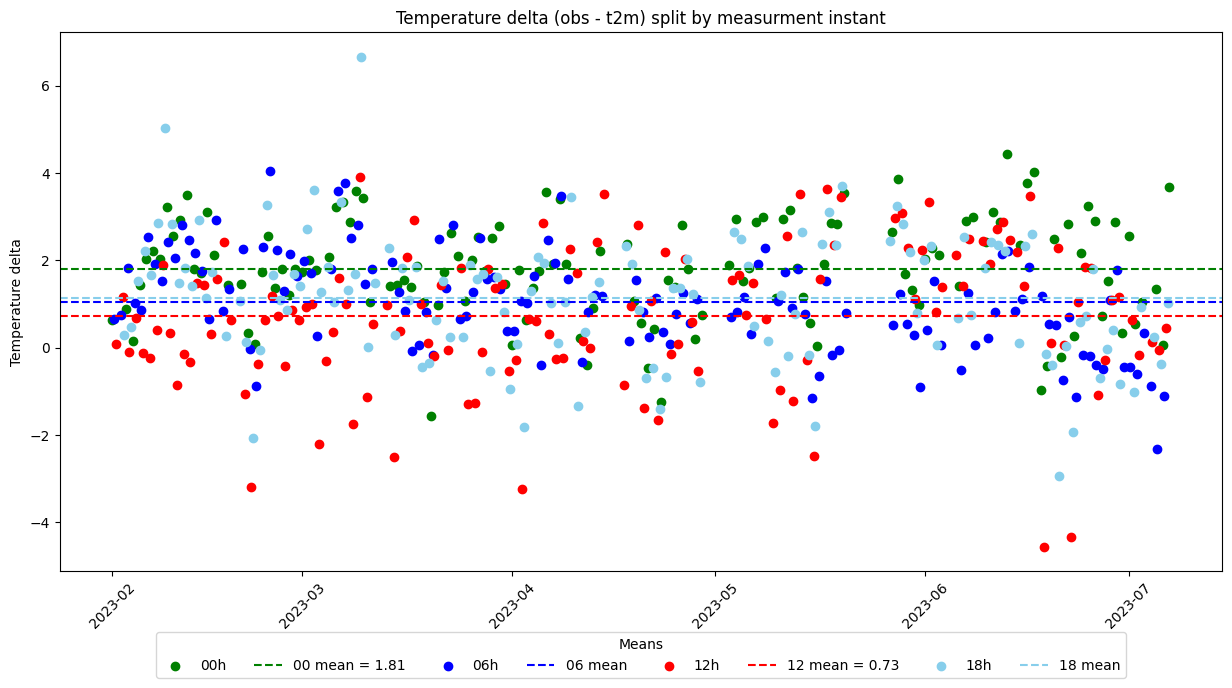

In [133]:
df_all = pd.concat([reduce_df(train_set), reduce_df(val_set), reduce_df(test_set)])
df_all = df_all.groupby('time').mean()
df_all['delta'] = df_all['temp'] + C_0 - df_all['t2m']

df_all = df_all.reset_index()
df00 = df_all[df_all['time'].dt.time == pd.Timestamp('00:00:00').time()]
df06 = df_all[df_all['time'].dt.time == pd.Timestamp('06:00:00').time()]
df12 = df_all[df_all['time'].dt.time == pd.Timestamp('12:00:00').time()]
df18 = df_all[df_all['time'].dt.time == pd.Timestamp('18:00:00').time()]

plt.figure(figsize=(15, 7))
plt.scatter(df00['time'], df00['delta'], label='00h', color="green")
plt.axhline(y=df00['delta'].mean(), color='green', linestyle='--', label=f"00 mean = {df00['delta'].mean():.2f}")
plt.scatter(df06['time'], df06['delta'], label='06h', color="blue")
plt.axhline(y=df06['delta'].mean(), color='blue', linestyle='--', label='06 mean')
plt.scatter(df12['time'], df12['delta'], label='12h', color="red")
plt.axhline(y=df12['delta'].mean(), color='red', linestyle='--', label=f"12 mean = {df12['delta'].mean():.2f}")
plt.scatter(df18['time'], df18['delta'], label='18h', color="skyblue")
plt.axhline(y=df18['delta'].mean(), color='skyblue', linestyle='--', label='18 mean')
plt.ylabel('Temperature delta')
plt.title('Temperature delta (obs - t2m) split by measurment instant')
plt.legend(title="Means", loc='upper center', bbox_to_anchor=(0.5, -0.10), ncols=8)

plt.xticks(rotation=45)
plt.show()

We can indeed see here that the observed temperatures seem to be relatively warmer at night, the measured temperature seems to be closer to the observed temperature at noon and both middle measurements (6h and 18h) are relatively close together.

We will define measurements instants: 
- 00:00:00 as HIGH
- 06:00:00 and 18:00:00 as MID
- 12:00:00 as LOW

We will encode this categorical data by using cyclical encoding. ([src](https://harrisonpim.com/blog/the-best-way-to-encode-dates-times-and-other-cyclical-features))

In [135]:
df_all['sin_hour'] = np.sin(2 * np.pi * df_all['time'].dt.hour / 24)
df_all['cos_hour'] = np.cos(2 * np.pi * df_all['time'].dt.hour / 24)

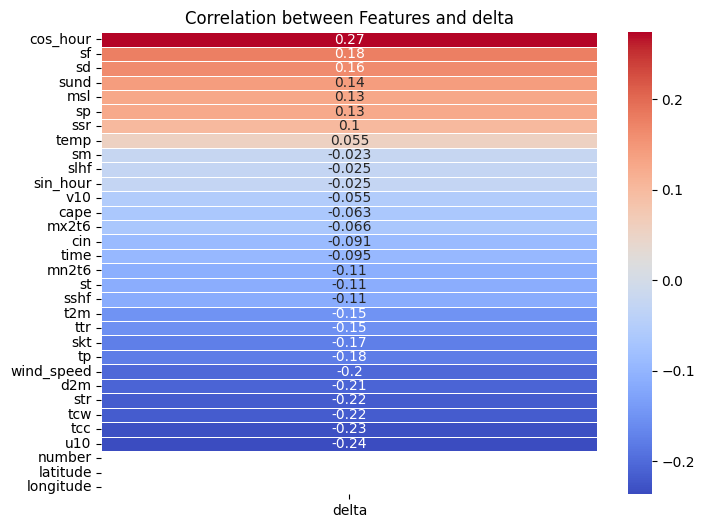

In [136]:
#df_all = df_all.groupby('time').mean()
df_all['delta'] = df_all['temp'] + C_0 - df_all['t2m']
df_all['wind_speed'] = np.sqrt(df_all['v10'] ** 2 + df_all['u10'] ** 2)

correlations = df_all.corr()['delta'].sort_values(ascending=False).drop('delta')

# Create a DataFrame to hold the correlation values
temp_corr_df = pd.DataFrame({'delta': correlations})

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(temp_corr_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation between Features and delta')
plt.show()

We can see here that cos_hour as well as u10 have the best explicative power. What is also interesting to note is that the east component (u) of wind holds has a higher more explicative power that the 'wind' feature and that sin_hour has bearly no correlation with delta.

In [142]:
def split_data(data, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=None):
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1."
    train_data, temp_data = train_test_split(data, train_size=train_ratio, random_state=random_state)
    relative_val_ratio = val_ratio / (val_ratio + test_ratio)
    val_data, test_data = train_test_split(temp_data, train_size=relative_val_ratio, random_state=random_state)

    return train_data, val_data, test_data

train_set, val_set, test_set = split_data(df_all, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42)

,time,number,latitude,longitude,cape,sp,tcw,sshf,slhf,msl,...,sf,tcc,tp,mx2t6,mn2t6,temp,delta,wind_speed,sin_hour,cos_hour
203,2023-03-28 06:00:00,25.5,50.75,4.25,1.114043,101740.794500,6.492774,1.376651e+06,-1.491158e+07,102700.635207,...,0.452306,75.040931,16.297055,272.983848,271.331103,0.5,1.565943,2.210540,1.000000e+00,6.123234e-17
66,2023-02-18 12:00:00,25.5,50.75,4.25,9.642388,101582.745847,17.067785,3.828224e+06,-5.729311e+06,102516.925980,...,0.000214,95.026374,3.784315,283.543567,280.935280,11.0,0.629561,6.321525,1.224647e-16,-1.000000e+00
388,2023-05-27 18:00:00,25.5,50.75,4.25,0.072367,101444.098740,12.591924,-1.346910e+07,-2.695470e+07,102351.261280,...,0.000000,1.168094,0.032745,292.821954,291.172024,21.5,3.242921,2.890357,-1.000000e+00,-1.836970e-16
255,2023-04-10 18:00:00,25.5,50.75,4.25,26.785776,100622.113733,18.792492,-3.662926e+06,-1.344222e+07,101537.800620,...,0.000000,96.474373,5.165212,288.394842,285.409238,10.8,-1.326098,4.773788,-1.000000e+00,-1.836970e-16
332,2023-05-06 12:00:00,25.5,50.75,4.25,60.175129,100701.388810,24.061883,-5.144366e+06,-1.790595e+07,101605.521090,...,0.000000,98.372952,3.594638,291.039081,284.624724,19.3,1.491030,2.845830,1.224647e-16,-1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2023-02-20 18:00:00,25.5,50.75,4.25,4.239918,101641.175640,13.614495,2.045693e+06,-6.235577e+06,102578.687380,...,0.000290,88.515166,4.256370,283.277559,281.292988,8.3,0.130015,3.674818,-1.000000e+00,-1.836970e-16
106,2023-03-01 12:00:00,25.5,50.75,4.25,0.001322,101847.751667,4.692079,-2.377926e+06,-5.665143e+06,102808.738567,...,0.091933,17.743891,0.305982,277.014198,269.343402,5.0,0.927914,4.680880,1.224647e-16,-1.000000e+00
270,2023-04-14 12:00:00,25.5,50.75,4.25,8.380426,99600.682800,13.249569,-3.297371e+06,-2.382641e+07,100518.897560,...,0.029746,84.431253,12.931676,283.429555,277.266563,13.7,3.517412,5.461069,1.224647e-16,-1.000000e+00
435,2023-06-11 06:00:00,25.5,50.75,4.25,22.521694,100574.248473,26.595121,-1.306769e+07,-3.042646e+07,101470.735940,...,0.000000,30.639793,0.789145,293.339912,290.798552,20.9,0.825533,1.816256,1.000000e+00,6.123234e-17


In [167]:
# drop all constant or non numerical values. we also drop columns containing nan values or values that are correlated with delta (temp and t2m)
X_train = train_set.drop(columns=['time', 'number', 'latitude', 'longitude', 'mx2t6', 'mn2t6', 'cin', 'delta', 'temp', 't2m'])
y_train = train_set['delta']
# selector = SelectKBest(k=10, score_func=f_regression)
# X_selected = selector.fit_transform(X_train, y_train.values.ravel())
# cols_idxs = selector.get_support(indices=True)
# X_train = X_train.iloc[:,cols_idxs].reset_index().drop(columns='index')

# rf_selected_features = X_train.columns.to_list()
# print(rf_selected_features)

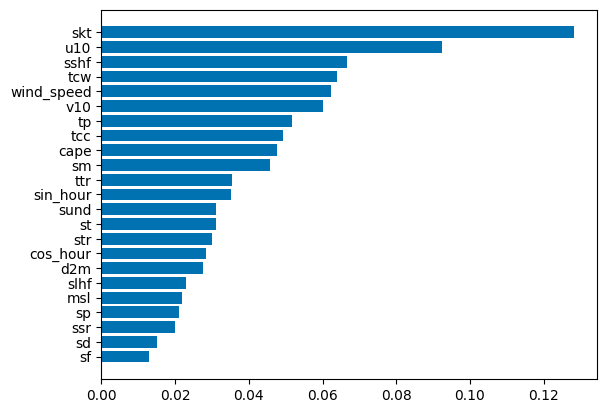

In [171]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

features = X_train.columns
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [176]:
#use to 
rfe = RFECV(rf,cv=5,scoring="neg_mean_squared_error")
rfe.fit(X_train,y_train)

RFECV(cv=5, estimator=RandomForestRegressor(), scoring='neg_mean_squared_error')

In [177]:
selected_features = np.array(features)[rfe.get_support()]
print(selected_features)

['cape' 'sp' 'tcw' 'sshf' 'slhf' 'msl' 'u10' 'v10' 'd2m' 'ssr' 'str' 'ttr'
 'sund' 'skt' 'sm' 'st' 'sd' 'tcc' 'tp' 'wind_speed' 'sin_hour' 'cos_hour']


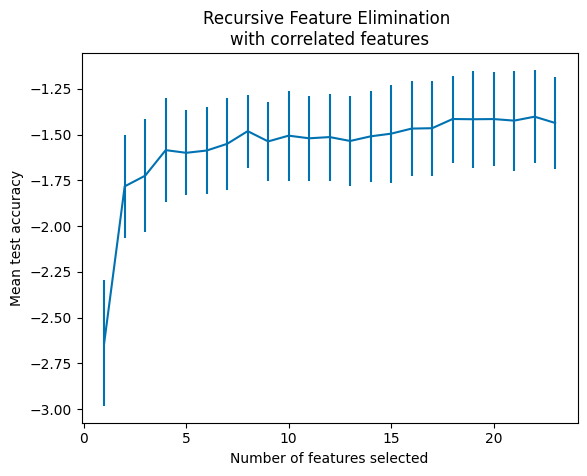

In [182]:
#from https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
n_scores = len(rfe.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfe.cv_results_["mean_test_score"],
    yerr=rfe.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

# Final run on test set
We selected model ... because it performed the best.

Mean mse: 3.178977327953455
Average baseline error:  1.68 degrees.
Average model error: 0.61 degrees.
Improvement over baseline: 63.87 %.
Accuracy: 85.16 %. (MAPE =  0.15 )
Mean r2_s: 0.7299033436738117


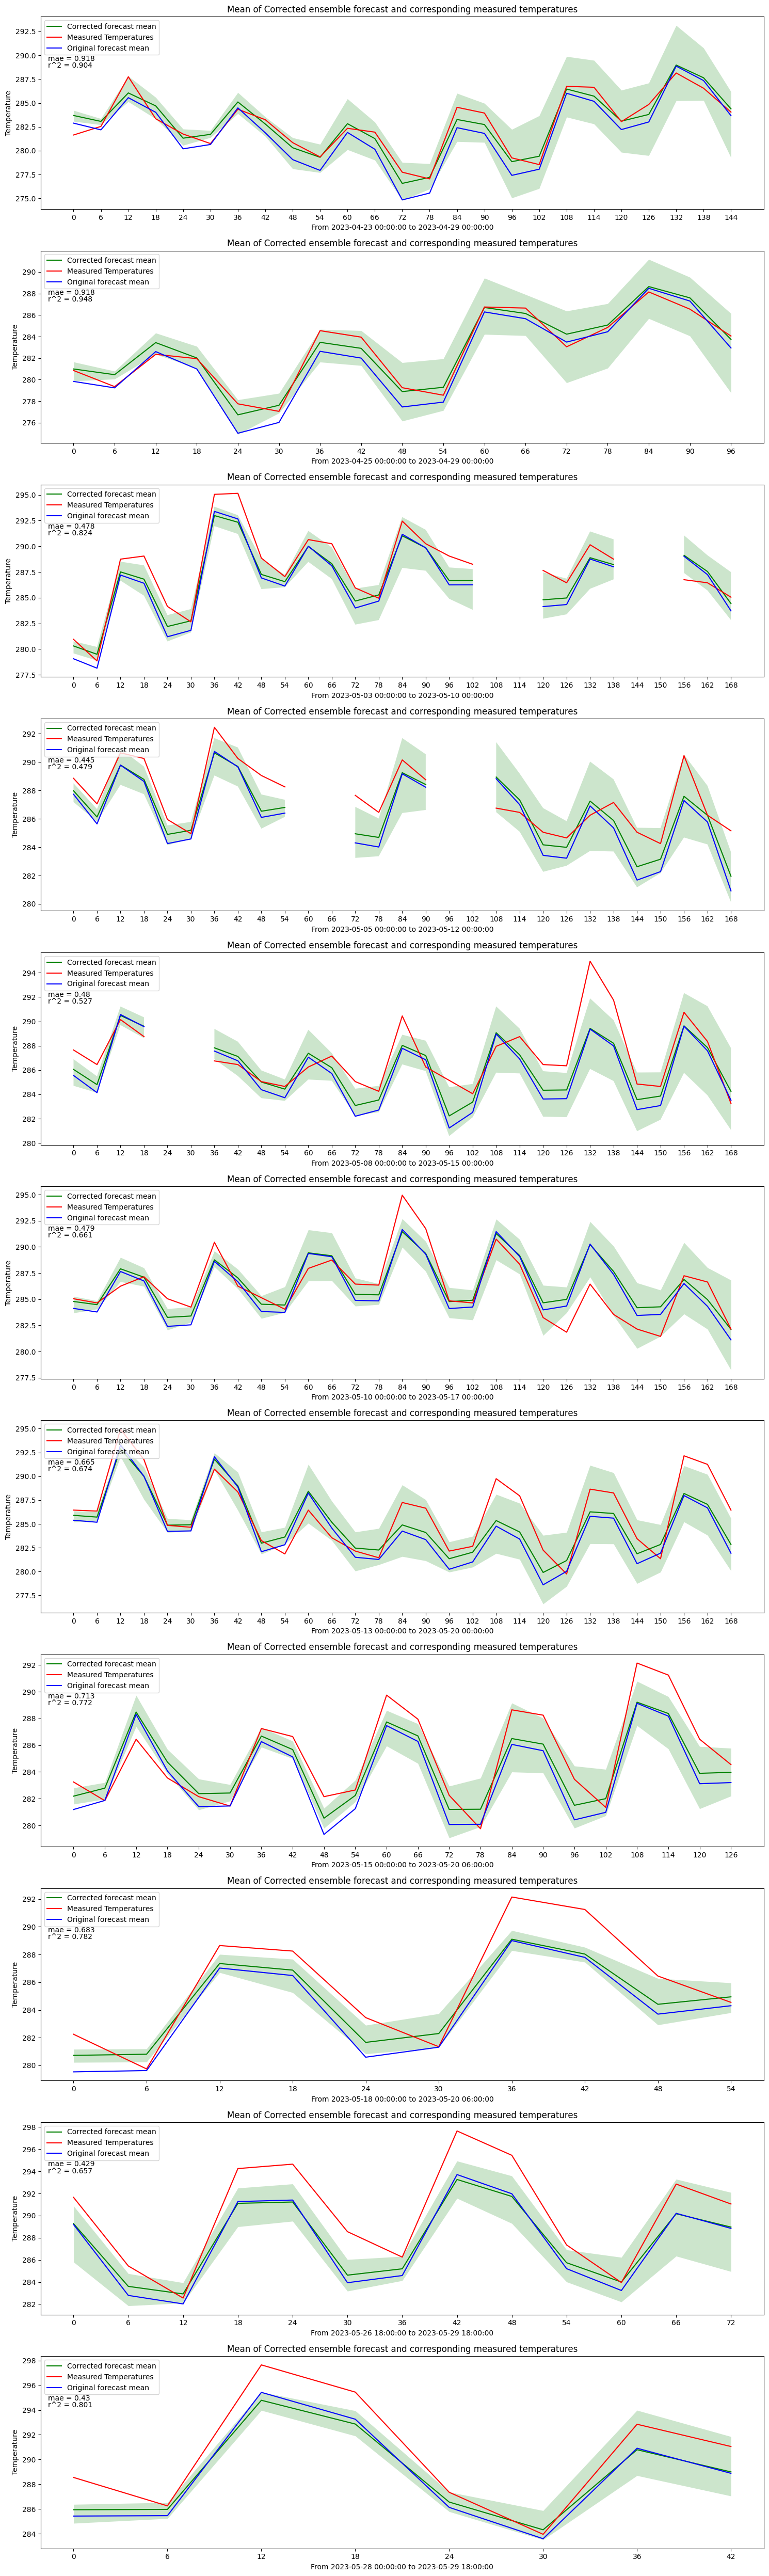

In [132]:
partial_transform_df_rf = partial(transform_df_rf_fc, rf_selected_features)
#correct_display(test_set, lasso, partial_transform_ridge, "Lasso")
correct_display(test_set, linear_regression, transform_df_lr_fc, "Linear reg")

# Correcting forecast

In [52]:
import re

def keep_digits(str):
    pattern = r'\D+' 
    return re.sub(pattern, '', str)

input_csv = "Forecast_13_04_2024.csv"
to_digits = keep_digits(input_csv)
output_csv_str = "Corr-" + to_digits[4:] + to_digits[2:4] + to_digits[:2] + "_TheBlaze.csv"
to_correct = pd.read_csv(f"weekly_forecast/{input_csv}")

#save dataframe to correct for later use
prev_fc = to_correct[['time', 't2m', 'number']]
df_corrected = correct_forecast(to_correct, rf_base, partial_transform_df_rf)
#df_corrected['t2m'] = 13.2 + C_0
#df_corrected = correct_forecast(to_correct, linear_regression, transform_df_lr_fc,)
df_corrected.to_csv(f"weekly_corrected/{output_csv_str}")

Displaying original and corrected forecasts

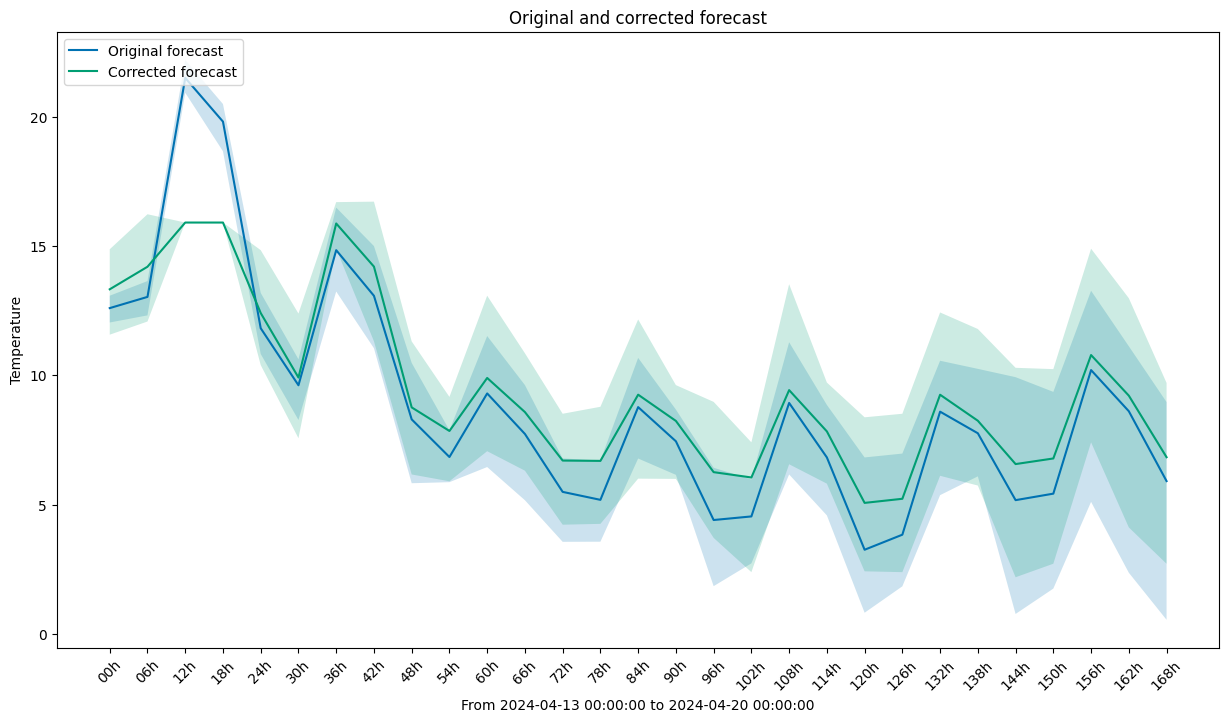

<Figure size 1500x800 with 0 Axes>

In [53]:
def display_prev_corrected(df_fc, df_corr):
    """
        Displays forecast and corrected forecast through model
        df_fc and fc_corr should be fully features dataframes that at least have columns 'time', 't2m' and 'number'
    """
    prev_fc_mean = df_fc[['time', 't2m']].groupby('time').mean().reset_index()
    corrected_mean = df_corr[['time', 't2m']].groupby('time').mean().reset_index()
    
    hours =  np.arange(0, 6 * len(corrected_mean), 6)

    prev_fc_mean['t2m'] = prev_fc_mean['t2m'] - C_0
    corrected_mean['t2m'] = corrected_mean['t2m'] - C_0

    start = prev_fc_mean['time'].min()
    end = prev_fc_mean['time'].max()

    fig, ax = plt.subplots(figsize=(15, 8))

    # Get min and max values of previous forecast
    pvt_prev_fc = df_fc[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_prev_fc.min(axis=1).values - C_0
    y_fc_max = pvt_prev_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    # get min and max value of corrected forecast
    pvt_corr_fc = df_corr[['time', 't2m', 'number']].pivot(index='time', columns='number', values='t2m')
    y_fc_min = pvt_corr_fc.min(axis=1).values - C_0
    y_fc_max = pvt_corr_fc.max(axis=1).values - C_0
    ax.fill_between(hours, y_fc_min, y_fc_max, alpha=.2, linewidth=0)

    plt.figure(figsize=(15, 8))
    ax.plot(hours, prev_fc_mean['t2m'], label='Original forecast')
    ax.plot(hours, corrected_mean['t2m'], label='Corrected forecast')
    ax.legend(loc='upper left')
    ax.set_xlabel(f"""From {start} to {end}""")
    ax.set_ylabel('Temperature')
    ax.set_title(f'Original and corrected forecast')
    ax.set_xticks(hours, [f"{h:02d}h" for h in hours], rotation=45)
    plt.show()

display_prev_corrected(prev_fc, df_corrected)